In [1]:
#Import necessary packages and data from UCI
from ucimlrepo import fetch_ucirepo 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# # metadata 
# print(air_quality.metadata) 
  
# # variable information 
#print(air_quality.variables) 

In [2]:
np.version.version

'1.24.3'

<h1><center>Investigating Air Quality of Italian Region using Modeling, Time Series and Clustering Analysis </center></h1>
<h2><center>Kimberley Maldonado, Emily Su, Derartu Werji</center></h2>

# Introduction

Air Quality originates from the UCI (https://archive.ics.uci.edu/dataset/360/air+quality) database. In this dataset we are given 9358 instances of hourly averaged responses of 5 metal oxide chemical sensors (March 2004 - April 2005) placed at road level in an Italian City. Specifically the 5 metal oxide sensors are CO, Non-Metanic Hydorcarbons, Benzene, Total Nitrogen Oxides (NOx), Nitrogen Dioxide (NO2). Given this data, our goal is to find the greatest contributors to air pollution and make future predictions regarding the concentration of the metal oxide compounds. To do this, we will discuss modeling techniques and time series analysis. We also seek to determine the impact of human behavior on air quality and if there are any discernible patterns that arise therein. For this, a clustering analysis based on hourly and daily data groupings is performed with PCA dimensionality reduction for visualization purposes.

# EDA

In [3]:
X

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     3/10/2004  18:00:00     2.6         1360       150      11.9   
1     3/10/2004  19:00:00     2.0         1292       112       9.4   
2     3/10/2004  20:00:00     2.2         1402        88       9.0   
3     3/10/2004  21:00:00     2.2         1376        80       9.2   
4     3/10/2004  22:00:00     1.6         1272        51       6.5   
...         ...       ...     ...          ...       ...       ...   
9352   4/4/2005  10:00:00     3.1         1314      -200      13.5   
9353   4/4/2005  11:00:00     2.4         1163      -200      11.4   
9354   4/4/2005  12:00:00     2.4         1142      -200      12.4   
9355   4/4/2005  13:00:00     2.1         1003      -200       9.5   
9356   4/4/2005  14:00:00     2.2         1071      -200      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0              1046      166          1056      113          1692   
1               955      103          1174       92          1559   
2               939      131          1140      114          1555   
3               948      172          1092      122          1584   
4               836      131          1205      116          1490   
...             ...      ...           ...      ...           ...   
9352           1101      472           539      190          1374   
9353           1027      353           604      179          1264   
9354           1063      293           603      175          1241   
9355            961      235           702      156          1041   
9356           1047      265           654      168          1129   

      PT08.S5(O3)     T    RH      AH  
0            1268  13.6  48.9  0.7578  
1             972  13.3  47.7  0.7255  
2            1074  11.9  54.0  0.7502  
3            1203  11.0  60.0  0.7867  
4            1110  11.2  59.6  0.7888  
...           ...   ...   ...     ...  
9352         1729  21.9  29.3  0.7568  
9353         1269  24.3  23.7  0.7119  
9354         1092  26.9  18.3  0.6406  
9355          770  28.3  13.5  0.5139  
9356          816  28.5  13.1  0.5028  

[9357 rows x 15 columns]

From here, we see that the data contains 9357 rows (days ranging from 2004/03/10 to 2005/04/04) and looks at various different times of different chemical compounds during these days. We can see the concentration of CO(GT), PT08.S1(CO), C6H6(GT), PT08.S2(NMHC), NOx(GT), PT08.S3(NOx), NO2(GT), PT08.S4(NO2), PT08.S5(O3), T,	RH, and AH. From here we will perform some exploratory data analysis to remove null values and potentially find the most important compounds to examine in our methods.

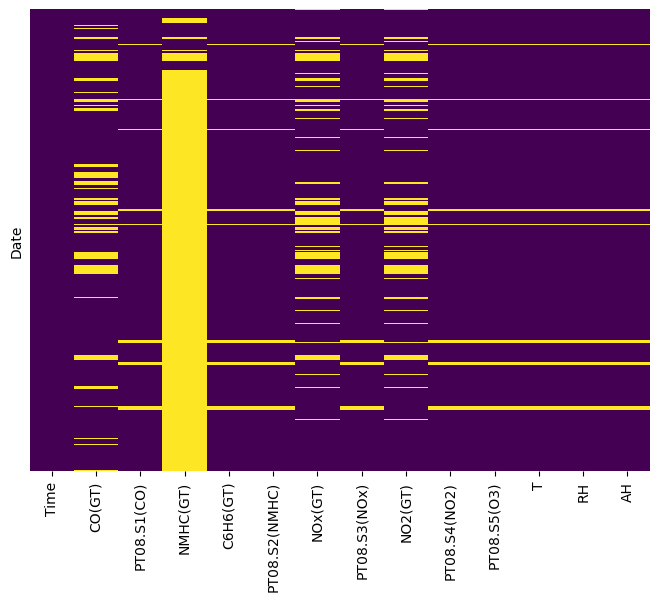

In [4]:
X.dropna(inplace=True)

#set index to the date column
X.set_index("Date", inplace=True) 
X.index = pd.to_datetime(X.index, format = '%m/%d/%Y')
X['Time'] = pd.to_datetime(X['Time'],format= '%H:%M:%S').dt.hour #Selecting only Hour value from the 'Time' Column.

X.replace(to_replace= -200, value= np.NaN, inplace= True)

#plot heatmap
plt.figure(figsize=(8,6))
sbn.heatmap(X.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

X['NMHC(GT)'].value_counts()

# 8443 values out of 9357 are -200. This coulmn is not needed thus dropping this coulumn .
X.drop('NMHC(GT)', axis=1, inplace=True)

#Fill in NaN values
X.fillna(X.median(), inplace=True)

The majority of the values for NMH(GT) are -200 so we can just remove this column entirely, to prevent the skewness of the column median. We want to then fill in the missing values (-200) with the column median instead of the column mean as the median can exlude any potential outliers. As such we can say that NHM(GT) does not contribute heavily to the amount of the pollution in the area.

<Axes: >

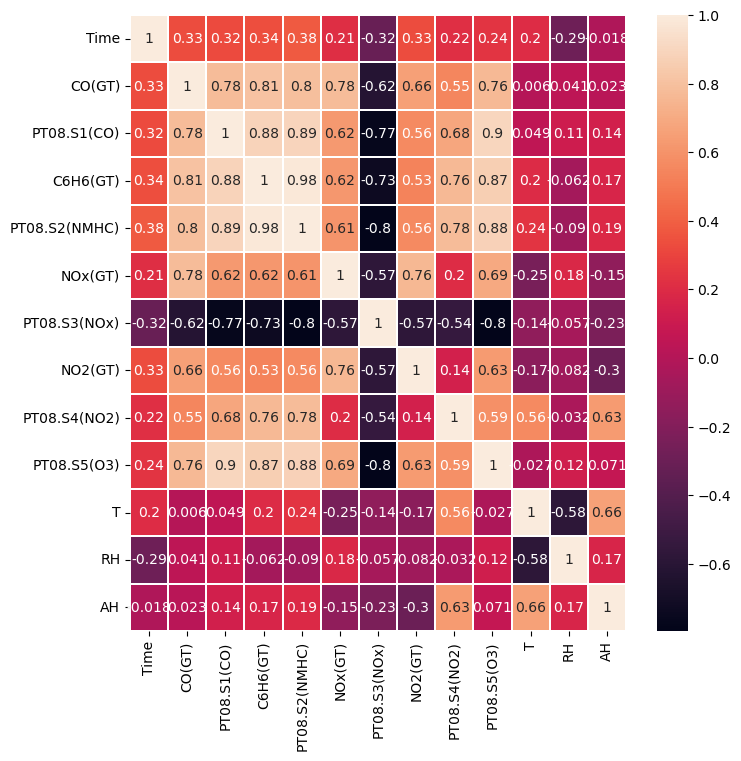

In [5]:
#plot correlation map
plt.figure(figsize=(8,8))
sbn.heatmap(X.corr(), annot=True, linewidths=.20)

When we make a model to train and test the data we can exclude the components T, RH, and AH as they have low correlations with the other chemical compounds. As seen in the heatmap above, T,RH, AH have the lowest correlations in each column compared to the other correlations. As such we can infer that these compounds also do not contribute heavily to the amount of pollution in the area.

Text(0.5, 1.0, "All Toxic Gases' Frequency by Month")

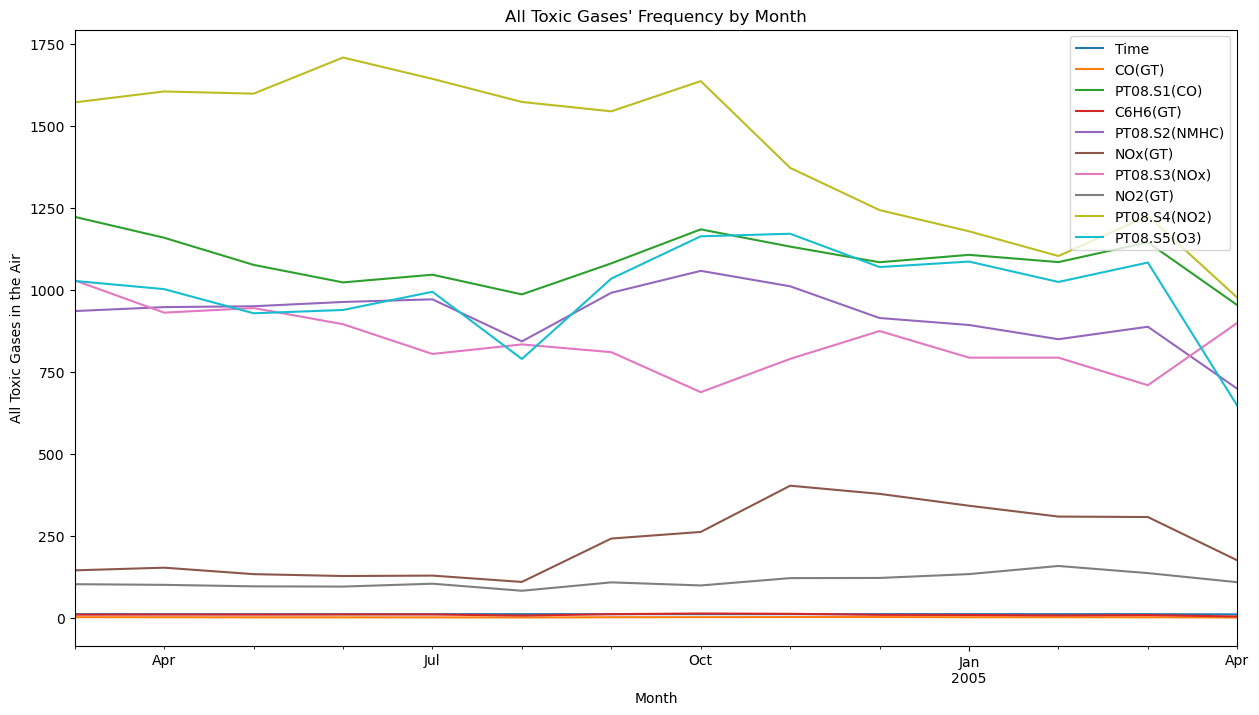

In [6]:
#plot monthly data to see trend 
X.drop(['RH','AH','T'], axis=1).resample('M').mean().plot(figsize = (15,8))
plt.legend(loc=1)
plt.xlabel('Month')
plt.ylabel('All Toxic Gases in the Air')
plt.title("All Toxic Gases' Frequency by Month")

In the plot above, we resample the daily chemical compound concentration into a Monthly mean so that the resulting plot does not look condensed. In the monthly trend we see that for PTO8.S4(NO2) slightly fluctuates from Mar2004 to Oct2004 then there is a sharp decrease until Feb2005. Then there is a slight increase again because it decreases again. It seems like going forward there will be a decrease in this specific component. We can arrive at a similar analysis for PTO8.S2(NMHC) and PTO8.S5(O3).

Now if we were to look at PTO8.S5(O3), there are slight fluctuations in the beginng of 2004 then there a sharp decrease in Jul2004 and then an increasing trend till Mar2005. After that there is a sharp decrease. In the future there may be slight extreme fluctuations but mostly will never exceed Mar2005. 

For PTO8.S1(CO), at first there is a slight negative trenf until Jun2004 then a small spike and sharp increase before Oct2004. Then is a slight fluctuation before sharply dropping in Mar2005. In the future there may be minimal fluctuations but mostly will never exceed Mar2005. 

For PT08.S3(NOx), there is a general decreasing trend until Oct2004 where it then turns into a generall increasing trend till Apr2005. In the future there maybe minimal fluctiations but generally should have an increasing trend after Mar2005.

For NOx(GT) and NO2(GT), it starts out as a semi constant trend until Aug2004 where is starts to slowly increase and then in Nov2005 it begins to decrease again. In the future we may see a similar pattern or the concentration levels will minimally flucate. 

For CO(GT) and C6H6(GT), there seems to a constant trend through the entire dataset. However since the future is uncertain, there could be minimal or extreme fluctuations.

In [7]:
#check if there still exists any null values
X.isnull().any()

Time             False
CO(GT)           False
PT08.S1(CO)      False
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)          False
PT08.S3(NOx)     False
NO2(GT)          False
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

As a final check before we get into analyzing the air quality data we want to make sure that there are no null values included.

# Method 1: Modeling

Treat X as having data from the same year, ignore the fact that there are 2 different years. As such we can test 3 different types of models (Linear Regression, K nearest neighbors, and Decision Tree) and compare the accuracies of the models. When we take a look into modeling we 

In [8]:
#Split the data into training and testing data
def traintestsplit(x, y):
    #train
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    
    return x_train, x_test, y_train, y_test

#Linear Regression Model 
def LRmodel(x, y, x_train, x_test, y_train, y_test, col):
    #Scaling and Transformation
    sc=RobustScaler()
    x_train=sc.fit_transform(x_train)
    x_test=sc.transform(x_test)

    #Creating and Training the Model¶
    lm = LinearRegression()
    lm.fit(x_train, y_train)

    #Prediction Model
    prediction = lm.predict(x_test)
    plt.scatter(y_test, prediction, c="blue", alpha=0.3)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Linear Regression Predicted vs Actual')
    plt.show()
    
    unique, counts = np.unique(y_test, return_counts=True)
    valcounts = np.stack((unique, counts), axis=-1)
    
    print("Show why data are condensed: \n")
    print(pd.DataFrame(valcounts, columns = ['Value', 'Frequency']))
    
    #train accuracy and test accuracy
    score_train = lm.score(x_train, y_train)
    score_test = lm.score(x_test, y_test)
    
    #Other metrics
    print('MAE:',metrics.mean_absolute_error(y_test, prediction))
    print('MSE:',metrics.mean_squared_error(y_test, prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, prediction)))
    
    return score_train, score_test

#KNN Regressor model
def KNNmodel(x, y, x_train, x_test, y_train, y_test):
    #model set up
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(x_train,y_train)

    #prediction model 
    prediction = knn.predict(x_test)
    plt.scatter(y_test, prediction, c="black", alpha=0.3)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('K-nearest Neighbors Predicted vs Actual')
    plt.show()
    
    unique, counts = np.unique(y_test, return_counts=True)
    valcounts = np.stack((unique, counts), axis=-1)
    
    print("Show why data are condensed: \n")
    print(pd.DataFrame(valcounts, columns = ['Value', 'Frequency']))
        
    #train accuracy and test accuracy
    score_train = knn.score(x_train,y_train)
    score_test = knn.score(x_test,y_test)
    
    return score_train, score_test

#Decision Tree Regressor model 
def DTRmodel(x, y, x_train, x_test, y_train, y_test):
    #model set up
    dreg=DecisionTreeRegressor()
    dreg.fit(x_train,y_train)
    
    #prediction model 
    prediction = dreg.predict(x_test)
    plt.scatter(y_test, prediction, c="green", alpha=0.3)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Decision Tree Predicted vs Actual')
    plt.show()
    
    unique, counts = np.unique(y_test, return_counts=True)
    valcounts = np.stack((unique, counts), axis=-1)
    
    print("Show why data are condensed: \n")
    print(pd.DataFrame(valcounts, columns = ['Value', 'Frequency']))
     
    #train accuracy and test accuracy
    score_train = dreg.score(x_train,y_train)
    score_test = dreg.score(x_test,y_test)
    
    return score_train, score_test

Linear Regression for:  CO(GT)


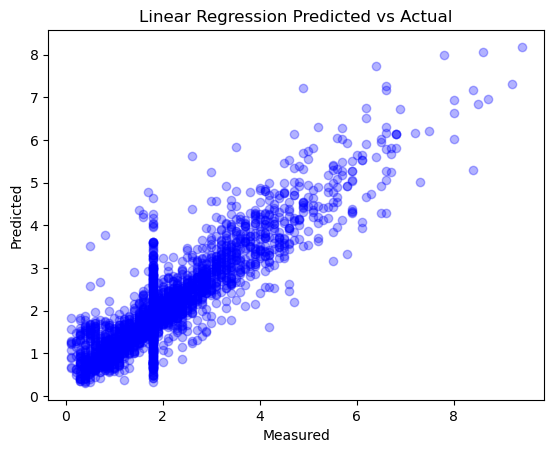

Show why data are condensed: 

    Value  Frequency
0     0.1       11.0
1     0.2       10.0
2     0.3       38.0
3     0.4       58.0
4     0.5       66.0
..    ...        ...
75    8.5        1.0
76    8.6        1.0
77    8.7        1.0
78    9.2        1.0
79    9.4        1.0

[80 rows x 2 columns]
MAE: 0.3931419489788728
MSE: 0.33159897026796653
RMSE: 0.5758463078530299
KNN for:  CO(GT)


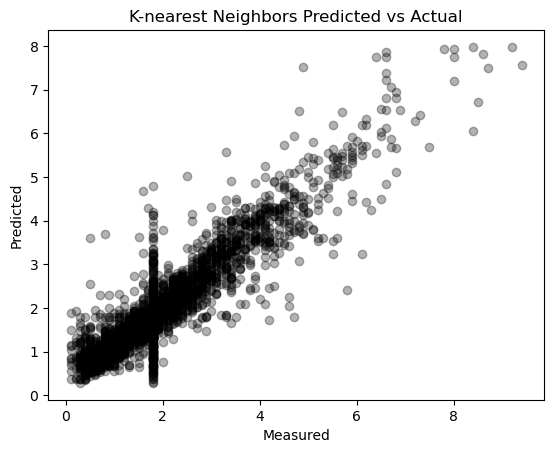

Show why data are condensed: 

    Value  Frequency
0     0.1       11.0
1     0.2       10.0
2     0.3       38.0
3     0.4       58.0
4     0.5       66.0
..    ...        ...
75    8.5        1.0
76    8.6        1.0
77    8.7        1.0
78    9.2        1.0
79    9.4        1.0

[80 rows x 2 columns]
Decision Tree for:  CO(GT)


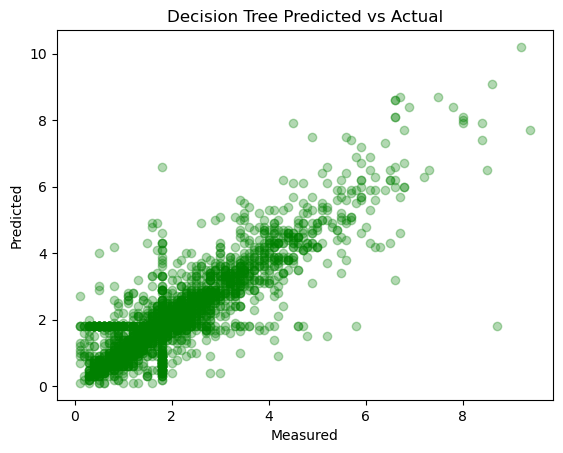

Show why data are condensed: 

    Value  Frequency
0     0.1       11.0
1     0.2       10.0
2     0.3       38.0
3     0.4       58.0
4     0.5       66.0
..    ...        ...
75    8.5        1.0
76    8.6        1.0
77    8.7        1.0
78    9.2        1.0
79    9.4        1.0

[80 rows x 2 columns]

Linear Regression for:  PT08.S1(CO)


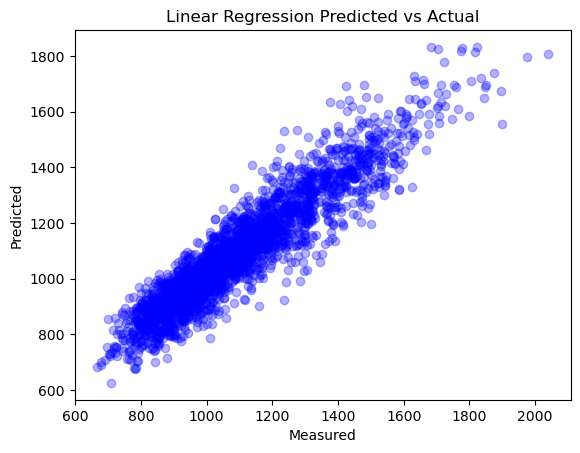

Show why data are condensed: 

      Value  Frequency
0     667.0        1.0
1     678.0        1.0
2     679.0        1.0
3     689.0        1.0
4     696.0        1.0
..      ...        ...
826  1875.0        1.0
827  1895.0        1.0
828  1898.0        1.0
829  1975.0        1.0
830  2040.0        1.0

[831 rows x 2 columns]
MAE: 58.7499085680324
MSE: 5945.119108585298
RMSE: 77.10459849182341
KNN for:  PT08.S1(CO)


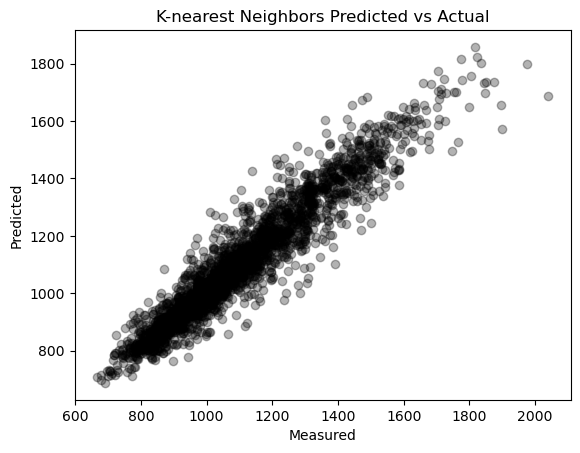

Show why data are condensed: 

      Value  Frequency
0     667.0        1.0
1     678.0        1.0
2     679.0        1.0
3     689.0        1.0
4     696.0        1.0
..      ...        ...
826  1875.0        1.0
827  1895.0        1.0
828  1898.0        1.0
829  1975.0        1.0
830  2040.0        1.0

[831 rows x 2 columns]
Decision Tree for:  PT08.S1(CO)


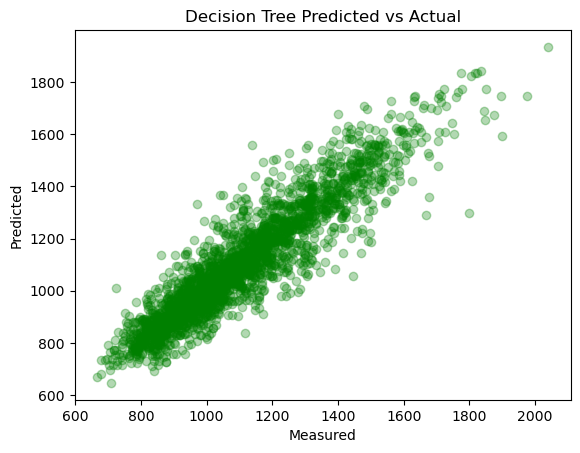

Show why data are condensed: 

      Value  Frequency
0     667.0        1.0
1     678.0        1.0
2     679.0        1.0
3     689.0        1.0
4     696.0        1.0
..      ...        ...
826  1875.0        1.0
827  1895.0        1.0
828  1898.0        1.0
829  1975.0        1.0
830  2040.0        1.0

[831 rows x 2 columns]

Linear Regression for:  C6H6(GT)


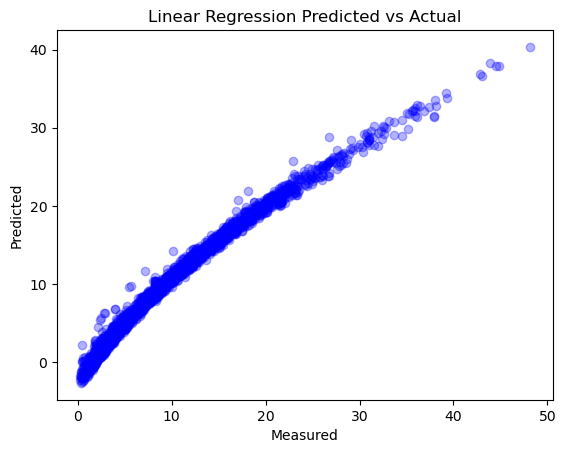

Show why data are condensed: 

     Value  Frequency
0      0.2        2.0
1      0.3        2.0
2      0.4        5.0
3      0.5        7.0
4      0.6        7.0
..     ...        ...
315   43.0        1.0
316   43.9        1.0
317   44.5        1.0
318   44.9        1.0
319   48.2        1.0

[320 rows x 2 columns]
MAE: 0.8228579399000064
MSE: 1.2369866000240188
RMSE: 1.112198992997215
KNN for:  C6H6(GT)


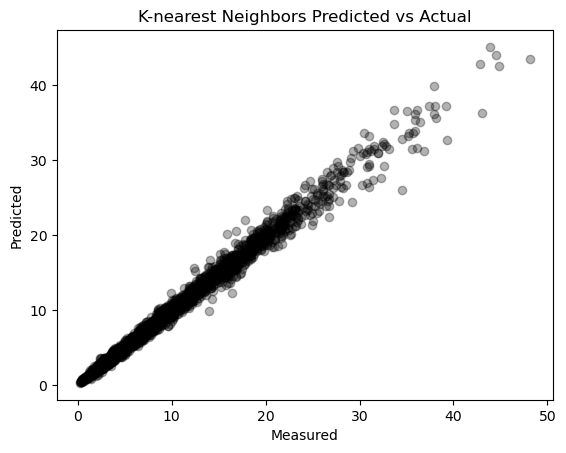

Show why data are condensed: 

     Value  Frequency
0      0.2        2.0
1      0.3        2.0
2      0.4        5.0
3      0.5        7.0
4      0.6        7.0
..     ...        ...
315   43.0        1.0
316   43.9        1.0
317   44.5        1.0
318   44.9        1.0
319   48.2        1.0

[320 rows x 2 columns]
Decision Tree for:  C6H6(GT)


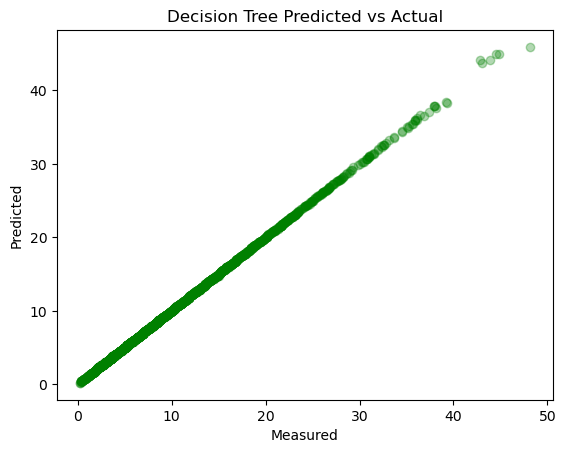

Show why data are condensed: 

     Value  Frequency
0      0.2        2.0
1      0.3        2.0
2      0.4        5.0
3      0.5        7.0
4      0.6        7.0
..     ...        ...
315   43.0        1.0
316   43.9        1.0
317   44.5        1.0
318   44.9        1.0
319   48.2        1.0

[320 rows x 2 columns]

Linear Regression for:  PT08.S2(NMHC)


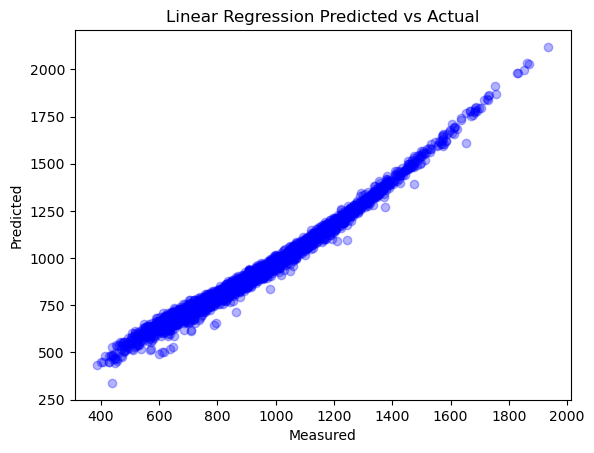

Show why data are condensed: 

      Value  Frequency
0     388.0        1.0
1     402.0        1.0
2     409.0        1.0
3     415.0        1.0
4     427.0        1.0
..      ...        ...
973  1831.0        1.0
974  1851.0        1.0
975  1862.0        1.0
976  1869.0        1.0
977  1935.0        1.0

[978 rows x 2 columns]
MAE: 27.30343347333943
MSE: 1258.1152200857562
RMSE: 35.46991993345567
KNN for:  PT08.S2(NMHC)


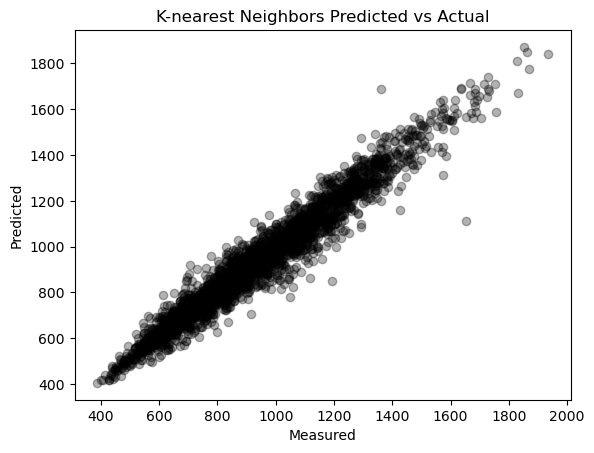

Show why data are condensed: 

      Value  Frequency
0     388.0        1.0
1     402.0        1.0
2     409.0        1.0
3     415.0        1.0
4     427.0        1.0
..      ...        ...
973  1831.0        1.0
974  1851.0        1.0
975  1862.0        1.0
976  1869.0        1.0
977  1935.0        1.0

[978 rows x 2 columns]
Decision Tree for:  PT08.S2(NMHC)


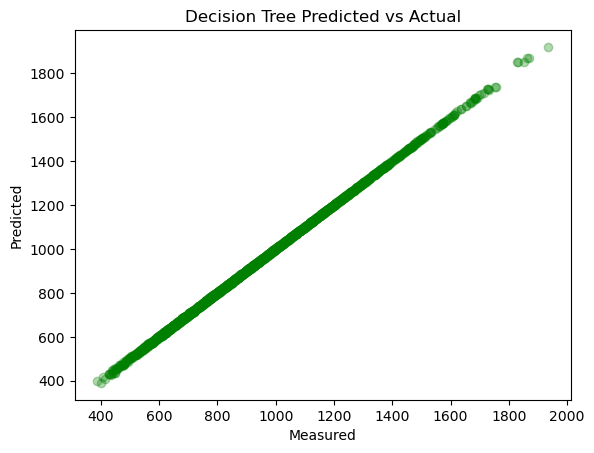

Show why data are condensed: 

      Value  Frequency
0     388.0        1.0
1     402.0        1.0
2     409.0        1.0
3     415.0        1.0
4     427.0        1.0
..      ...        ...
973  1831.0        1.0
974  1851.0        1.0
975  1862.0        1.0
976  1869.0        1.0
977  1935.0        1.0

[978 rows x 2 columns]

Linear Regression for:  NOx(GT)


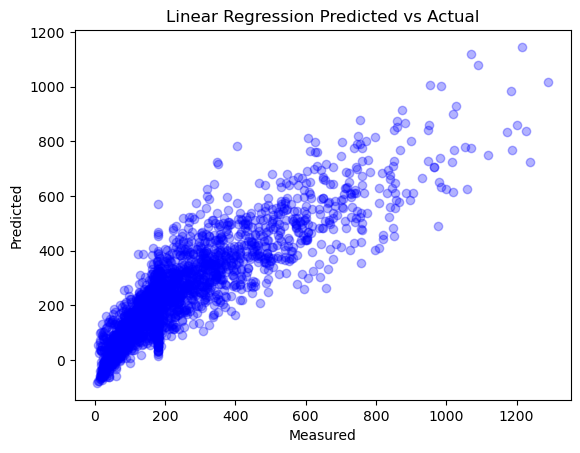

Show why data are condensed: 

      Value  Frequency
0       7.0        1.0
1      10.0        2.0
2      12.0        2.0
3      14.0        3.0
4      15.0        4.0
..      ...        ...
653  1200.0        1.0
654  1216.0        1.0
655  1227.0        1.0
656  1237.0        1.0
657  1290.0        1.0

[658 rows x 2 columns]
MAE: 64.322930689787
MSE: 8223.538194065053
RMSE: 90.6837261809695
KNN for:  NOx(GT)


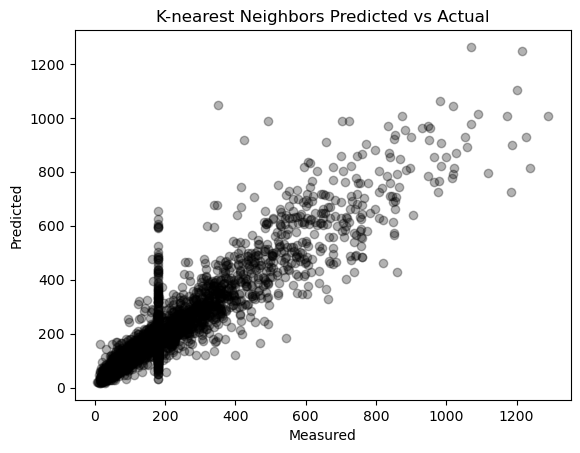

Show why data are condensed: 

      Value  Frequency
0       7.0        1.0
1      10.0        2.0
2      12.0        2.0
3      14.0        3.0
4      15.0        4.0
..      ...        ...
653  1200.0        1.0
654  1216.0        1.0
655  1227.0        1.0
656  1237.0        1.0
657  1290.0        1.0

[658 rows x 2 columns]
Decision Tree for:  NOx(GT)


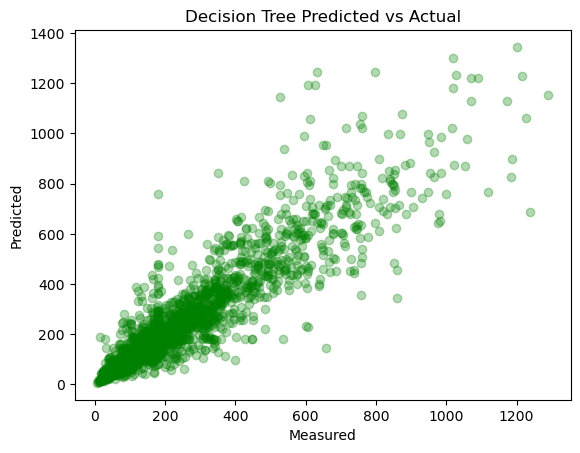

Show why data are condensed: 

      Value  Frequency
0       7.0        1.0
1      10.0        2.0
2      12.0        2.0
3      14.0        3.0
4      15.0        4.0
..      ...        ...
653  1200.0        1.0
654  1216.0        1.0
655  1227.0        1.0
656  1237.0        1.0
657  1290.0        1.0

[658 rows x 2 columns]

Linear Regression for:  PT08.S3(NOx)


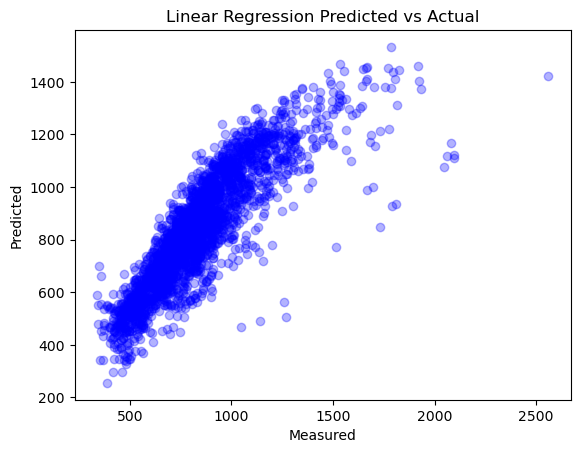

Show why data are condensed: 

      Value  Frequency
0     340.0        1.0
1     341.0        1.0
2     345.0        1.0
3     349.0        1.0
4     355.0        1.0
..      ...        ...
909  2047.0        1.0
910  2061.0        1.0
911  2081.0        1.0
912  2095.0        2.0
913  2559.0        1.0

[914 rows x 2 columns]
MAE: 86.69304607751782
MSE: 15891.779995086972
RMSE: 126.0626034757611
KNN for:  PT08.S3(NOx)


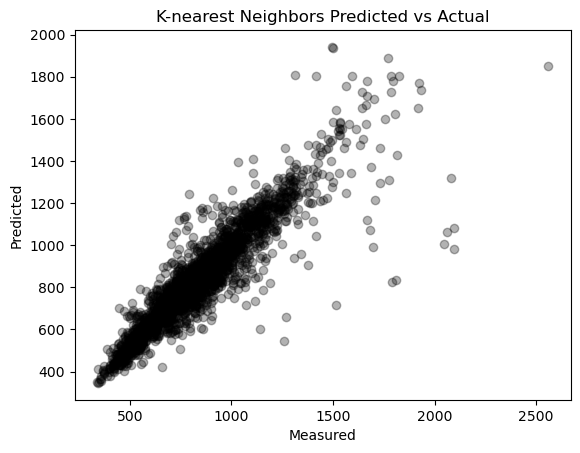

Show why data are condensed: 

      Value  Frequency
0     340.0        1.0
1     341.0        1.0
2     345.0        1.0
3     349.0        1.0
4     355.0        1.0
..      ...        ...
909  2047.0        1.0
910  2061.0        1.0
911  2081.0        1.0
912  2095.0        2.0
913  2559.0        1.0

[914 rows x 2 columns]
Decision Tree for:  PT08.S3(NOx)


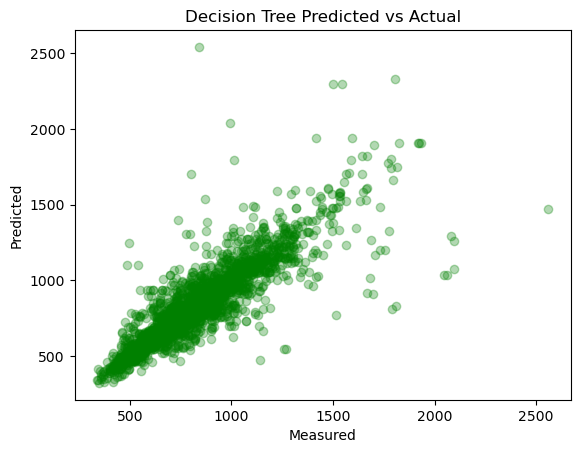

Show why data are condensed: 

      Value  Frequency
0     340.0        1.0
1     341.0        1.0
2     345.0        1.0
3     349.0        1.0
4     355.0        1.0
..      ...        ...
909  2047.0        1.0
910  2061.0        1.0
911  2081.0        1.0
912  2095.0        2.0
913  2559.0        1.0

[914 rows x 2 columns]

Linear Regression for:  NO2(GT)


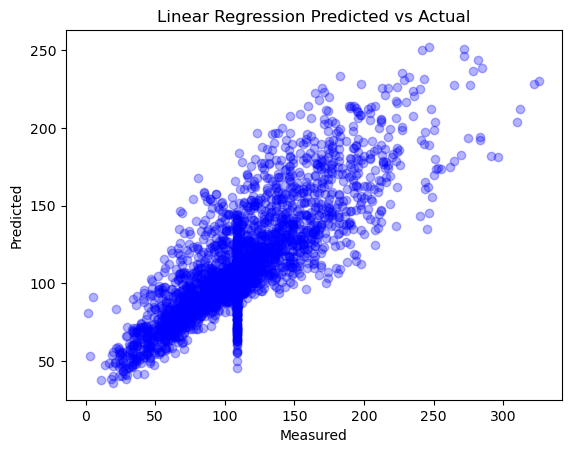

Show why data are condensed: 

     Value  Frequency
0      2.0        1.0
1      3.0        1.0
2      5.0        1.0
3     11.0        1.0
4     14.0        1.0
..     ...        ...
244  296.0        1.0
245  310.0        1.0
246  312.0        1.0
247  322.0        1.0
248  326.0        1.0

[249 rows x 2 columns]
MAE: 19.07357887531894
MSE: 648.2172314514747
RMSE: 25.46011059385789
KNN for:  NO2(GT)


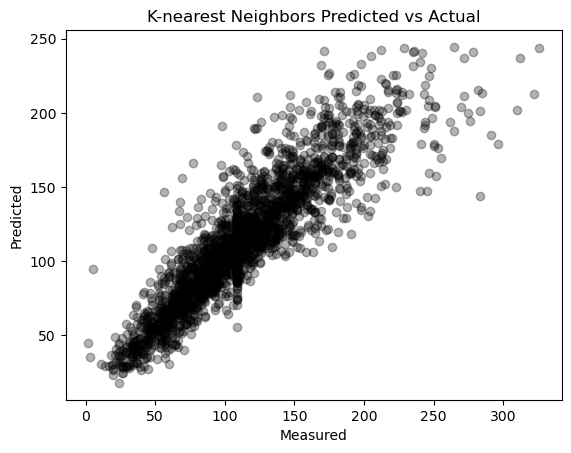

Show why data are condensed: 

     Value  Frequency
0      2.0        1.0
1      3.0        1.0
2      5.0        1.0
3     11.0        1.0
4     14.0        1.0
..     ...        ...
244  296.0        1.0
245  310.0        1.0
246  312.0        1.0
247  322.0        1.0
248  326.0        1.0

[249 rows x 2 columns]
Decision Tree for:  NO2(GT)


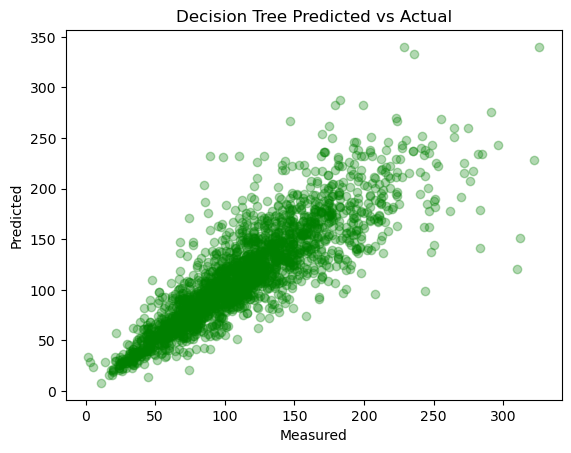

Show why data are condensed: 

     Value  Frequency
0      2.0        1.0
1      3.0        1.0
2      5.0        1.0
3     11.0        1.0
4     14.0        1.0
..     ...        ...
244  296.0        1.0
245  310.0        1.0
246  312.0        1.0
247  322.0        1.0
248  326.0        1.0

[249 rows x 2 columns]

Linear Regression for:  PT08.S4(NO2)


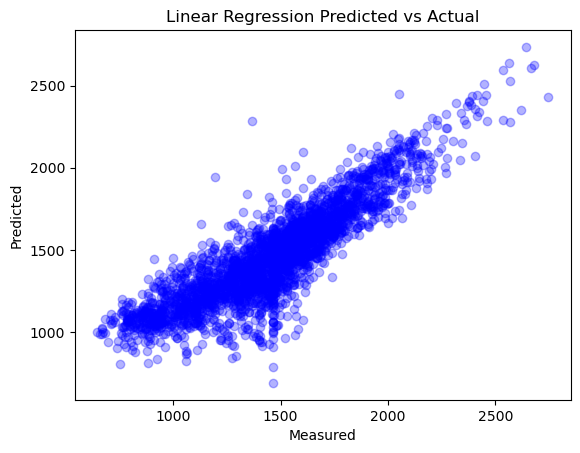

Show why data are condensed: 

       Value  Frequency
0      647.0        1.0
1      660.0        1.0
2      667.0        1.0
3      668.0        1.0
4      669.0        1.0
...      ...        ...
1151  2617.0        1.0
1152  2643.0        1.0
1153  2667.0        1.0
1154  2679.0        1.0
1155  2746.0        1.0

[1156 rows x 2 columns]
MAE: 124.66078040627707
MSE: 25947.744130058534
RMSE: 161.083034892128
KNN for:  PT08.S4(NO2)


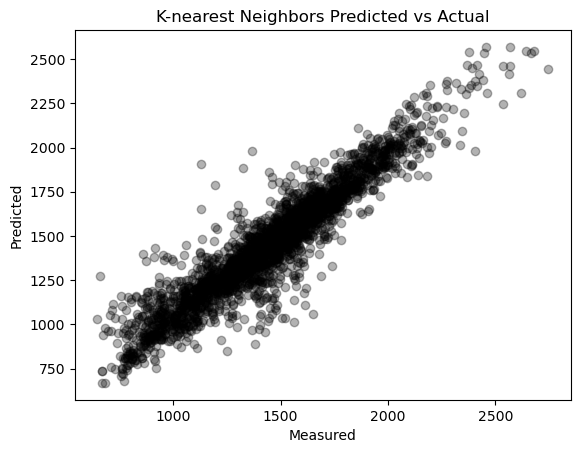

Show why data are condensed: 

       Value  Frequency
0      647.0        1.0
1      660.0        1.0
2      667.0        1.0
3      668.0        1.0
4      669.0        1.0
...      ...        ...
1151  2617.0        1.0
1152  2643.0        1.0
1153  2667.0        1.0
1154  2679.0        1.0
1155  2746.0        1.0

[1156 rows x 2 columns]
Decision Tree for:  PT08.S4(NO2)


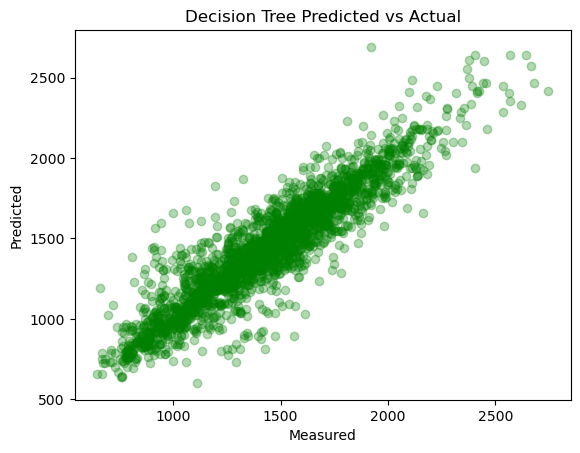

Show why data are condensed: 

       Value  Frequency
0      647.0        1.0
1      660.0        1.0
2      667.0        1.0
3      668.0        1.0
4      669.0        1.0
...      ...        ...
1151  2617.0        1.0
1152  2643.0        1.0
1153  2667.0        1.0
1154  2679.0        1.0
1155  2746.0        1.0

[1156 rows x 2 columns]

Linear Regression for:  PT08.S5(O3)


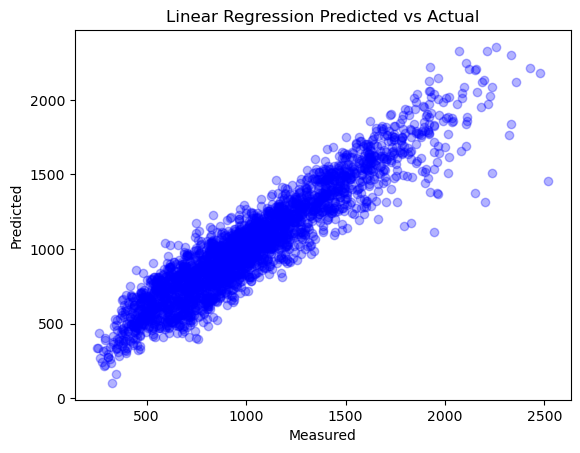

Show why data are condensed: 

       Value  Frequency
0      252.0        1.0
1      257.0        1.0
2      262.0        1.0
3      263.0        1.0
4      274.0        1.0
...      ...        ...
1237  2334.0        1.0
1238  2359.0        1.0
1239  2426.0        1.0
1240  2480.0        1.0
1241  2519.0        1.0

[1242 rows x 2 columns]
MAE: 107.915861165012
MSE: 19837.715262496542
RMSE: 140.8464243866224
KNN for:  PT08.S5(O3)


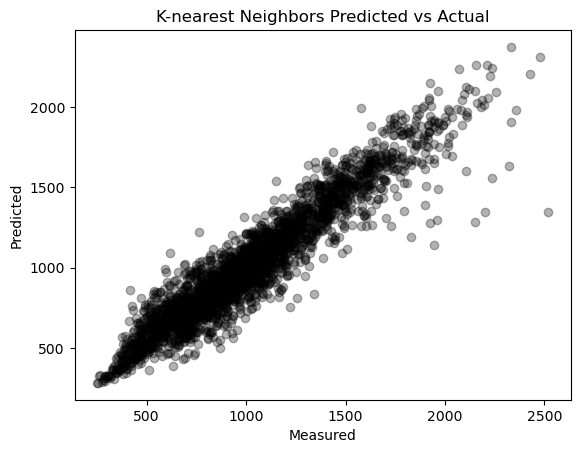

Show why data are condensed: 

       Value  Frequency
0      252.0        1.0
1      257.0        1.0
2      262.0        1.0
3      263.0        1.0
4      274.0        1.0
...      ...        ...
1237  2334.0        1.0
1238  2359.0        1.0
1239  2426.0        1.0
1240  2480.0        1.0
1241  2519.0        1.0

[1242 rows x 2 columns]
Decision Tree for:  PT08.S5(O3)


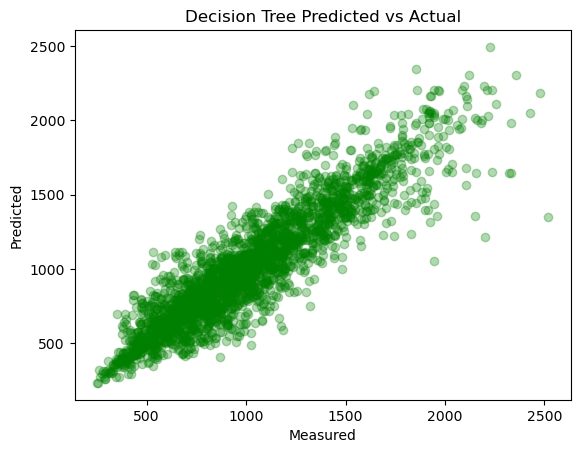

Show why data are condensed: 

       Value  Frequency
0      252.0        1.0
1      257.0        1.0
2      262.0        1.0
3      263.0        1.0
4      274.0        1.0
...      ...        ...
1237  2334.0        1.0
1238  2359.0        1.0
1239  2426.0        1.0
1240  2480.0        1.0
1241  2519.0        1.0

[1242 rows x 2 columns]



In [9]:
#select the top features that impact the pollution the most
features = X.drop(['Time', 'RH','AH','T'], axis=1)

index = ['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor']
train_acc = []
test_acc = []
#loop to run all possible features and models
for f in range(0, features.shape[1]):
    ftrain_acc = []
    ftest_acc = []
    
    x = features.drop(features.iloc[:, f: f+1], axis=1)
    y = features.iloc[:, f: f+1]
    
    x_train, x_test, y_train, y_test = traintestsplit(x, y)
    print("Linear Regression for: ", features.columns[f])
    score_train, score_test = LRmodel(x, y, x_train, x_test, y_train, y_test, features.columns[f])
    
    ftrain_acc.append(score_train)
    ftest_acc.append(score_test)
       
    print("KNN for: ", features.columns[f])
    score_train, score_test = KNNmodel(x, y, x_train, x_test, y_train, y_test)
    
    ftrain_acc.append(score_train)
    ftest_acc.append(score_test)
       
    print("Decision Tree for: ", features.columns[f])
    score_train, score_test = DTRmodel(x, y, x_train, x_test, y_train, y_test)
    
    ftrain_acc.append(score_train)
    ftest_acc.append(score_test)
    
    train_acc.append(ftrain_acc)
    test_acc.append(ftest_acc)
    
    print()

Overall, all the results of the three models have positive linear trend. In certain areas the graphs look condensed because across multiple days the chemical compounds have the same concentration but we are predicting multiple different concentrations from the model.   

In [10]:
#put the final accuracies into a dataframe so that it is easier to read output 
final_train_accuracy = pd.DataFrame(np.transpose(train_acc), columns = features.columns, index = index)
final_test_accuracy = pd.DataFrame(np.transpose(test_acc), columns = features.columns, index = index)

In [11]:
final_train_accuracy

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
Linear Regression        0.807170     0.865335  0.973293       0.980180   
KNN Regressor            0.896629     0.941895  0.991516       0.966445   
Decision Tree Regressor  0.999508     1.000000  1.000000       1.000000   

                          NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  \
Linear Regression        0.779198      0.752651  0.678434      0.777632   
KNN Regressor            0.882577      0.901434  0.871342      0.926651   
Decision Tree Regressor  0.999717      1.000000  0.999993      1.000000   

                         PT08.S5(O3)  
Linear Regression           0.872607  
KNN Regressor               0.937787  
Decision Tree Regressor     1.000000

We see that for each of the chemical compounds that the KNN Regresor and the Decision Tree regressor perform the best. Looking at this we can assume that the Decce

In [12]:
#Overall Model Accuracy
pd.DataFrame(np.mean(np.asarray(final_train_accuracy), axis = 1), columns = ['Model Acc'], index = index)

Model Acc
Linear Regression         0.831833
KNN Regressor             0.924031
Decision Tree Regressor   0.999913

From the traning accuracies of the models for each of the chemical compounds we see that the KNN Regressor and Decision Tree Regressor have better performance than linear regression. Taking 

In [13]:
final_test_accuracy

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
Linear Regression        0.804280     0.866200  0.975721       0.981030   
KNN Regressor            0.836742     0.908355  0.988244       0.948095   
Decision Tree Regressor  0.728223     0.849916  0.999908       0.999928   

                          NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  \
Linear Regression        0.777964      0.746645  0.677559      0.769184   
KNN Regressor            0.833934      0.836002  0.801106      0.878895   
Decision Tree Regressor  0.823566      0.730325  0.717462      0.834561   

                         PT08.S5(O3)  
Linear Regression           0.870142  
KNN Regressor               0.894365  
Decision Tree Regressor     0.826929

In [14]:
#Overall Model Accuracy
pd.DataFrame(np.mean(np.asarray(final_test_accuracy), axis = 1), columns = ['Model Acc'], index = index)

Model Acc
Linear Regression         0.829858
KNN Regressor             0.880637
Decision Tree Regressor   0.834535

# Method 2: Time Series Analysis 

Since we have both 2004 and 2005 data lets split the 2004 data into training data and 2005 into testing data and predict 2005 values. To create a more general analysis, we can resample the data into Months.

In [15]:
#split original data into training and testing data  -- lets say that
train = features[features.index < pd.to_datetime("2005-01-01", format = '%Y-%m-%d')].resample('M').mean()
test = features[features.index >= pd.to_datetime("2005-01-01", format = '%Y-%m-%d')].resample('M').mean()

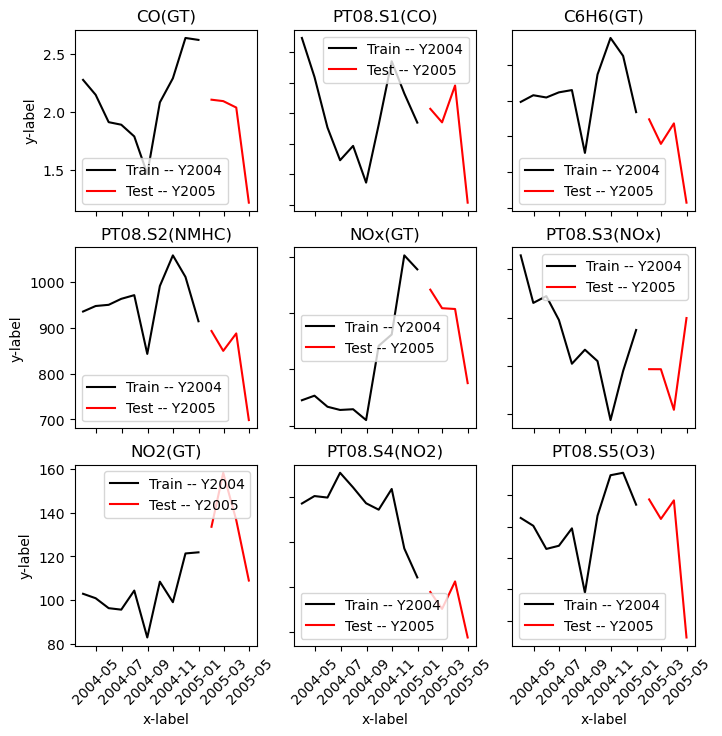

In [16]:
#Plot training and testing data 
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs[0, 0].plot(train['CO(GT)'], color = "black", label = 'Train -- Y2004')
axs[0, 0].plot(test['CO(GT)'], color = "red", label = 'Test -- Y2005')
axs[0, 0].set_title('CO(GT)')
axs[0, 0].legend()

axs[0, 1].plot(train['PT08.S1(CO)'], color = "black", label = 'Train -- Y2004')
axs[0, 1].plot(test['PT08.S1(CO)'], color = "red", label = 'Test -- Y2005')
axs[0, 1].set_title('PT08.S1(CO)')
axs[0, 1].legend()

axs[0, 2].plot(train['C6H6(GT)'], color = "black", label = 'Train -- Y2004')
axs[0, 2].plot(test['C6H6(GT)'], color = "red", label = 'Test -- Y2005')
axs[0, 2].set_title('C6H6(GT)')
axs[0, 2].legend()

axs[1, 0].plot(train['PT08.S2(NMHC)'], color = "black", label = 'Train -- Y2004')
axs[1, 0].plot(test['PT08.S2(NMHC)'], color = "red", label = 'Test -- Y2005')
axs[1, 0].set_title('PT08.S2(NMHC)')
axs[1, 0].legend()

axs[1, 1].plot(train['NOx(GT)'], color = "black", label = 'Train -- Y2004')
axs[1, 1].plot(test['NOx(GT)'], color = "red", label = 'Test -- Y2005')
axs[1, 1].set_title('NOx(GT)')
axs[1, 1].legend()

axs[1, 2].plot(train['PT08.S3(NOx)'], color = "black", label = 'Train -- Y2004')
axs[1, 2].plot(test['PT08.S3(NOx)'], color = "red", label = 'Test -- Y2005')
axs[1, 2].set_title('PT08.S3(NOx)')
axs[1, 2].legend()

axs[2, 0].plot(train['NO2(GT)'], color = "black", label = 'Train -- Y2004')
axs[2, 0].plot(test['NO2(GT)'], color = "red", label = 'Test -- Y2005')
axs[2, 0].set_title('NO2(GT)')
axs[2, 0].legend()

axs[2, 1].plot(train['PT08.S4(NO2)'], color = "black", label = 'Train -- Y2004')
axs[2, 1].plot(test['PT08.S4(NO2)'], color = "red", label = 'Test -- Y2005')
axs[2, 1].set_title('PT08.S4(NO2)')
axs[2, 1].legend()

axs[2, 2].plot(train['PT08.S5(O3)'], color = "black", label = 'Train -- Y2004')
axs[2, 2].plot(test['PT08.S5(O3)'], color = "red", label = 'Test -- Y2005')
axs[2, 2].set_title('PT08.S5(O3)')
axs[2, 2].legend()

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
    ax.label_outer()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

The subplot displays the monthly averages of the chemical compound concentrations, the black line displays data before and not including Jan2005 and the red line displays data on and after Jan2005. As such there is a break between the black and red line. 

In [17]:
##https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
#SARIMAX modeling following the link above
def times_series_modeling(train, col):
    pred_date=[train.index[-1]+ DateOffset(months=x)for x in range(0,24)]

    pred_date=pd.DataFrame(index=pred_date[1:],columns=train.columns)

    data=pd.concat([train,pred_date])

    model = SARIMAX(train[col], order = (1,0,1))
    history=model.fit()

    #print(history.summary())
    modelingt = train.copy()

    modelingt['forecast']=history.predict(start=11,end=103,dynamic=True)
    #train[['C6H6(GT)','forecast']].plot(figsize=(12,8))

    pred_date=[modelingt.index[-1]+ DateOffset(months=x)for x in range(0,24)]

    pred_date=pd.DataFrame(index=pred_date[1:],columns=modelingt.columns)

    data=pd.concat([modelingt,pred_date])

    data['forecast'] = history.predict(start = 7, end = 120, dynamic= True)  
    
    data[[col, 'forecast']].plot(figsize=(6, 4))
    
    return data

#Method to calculate the accuracy of the SARIMAX model
#if the values are within .5 of each other then we say that it is accurate
def accuracy (data, test, col):
    #normalize the data to make finding the accuracy easier 
    normalized_data=(data - data.min())/(data.max()-data.min())
    normalized_test=(test - test.min())/(test.max()-test.min())
    
    comparison = normalized_data[(normalized_data.index >= '2004-10-31') & (normalized_data.index <= '2005-04-30')]
    actual = np.append(np.asarray(comparison[col].dropna()), np.asarray(normalized_test[col]))
    forecast = np.asarray(comparison['forecast'])
    match = 0

    for i in range(0, len(actual)):
        if (abs(actual[i] - forecast[i]) <= .55):
            match += 1
    accuracy = match/len(actual)
    
    return np.round(accuracy, 4)

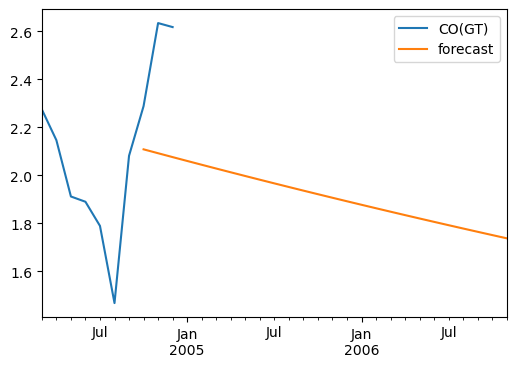

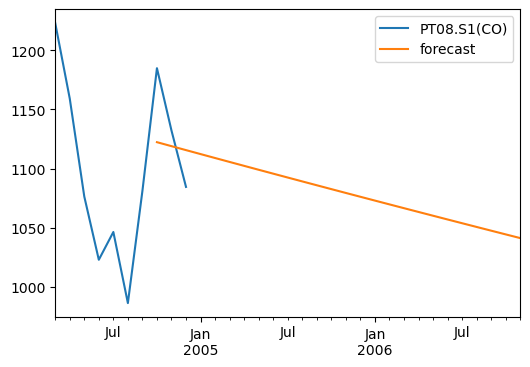

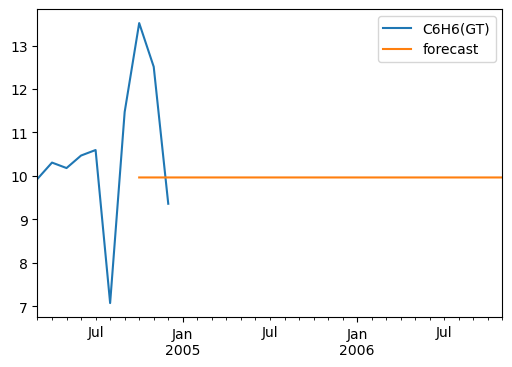

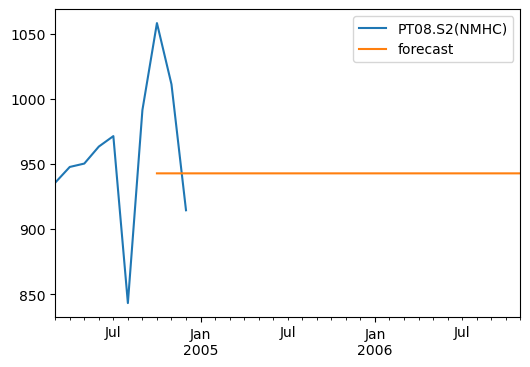

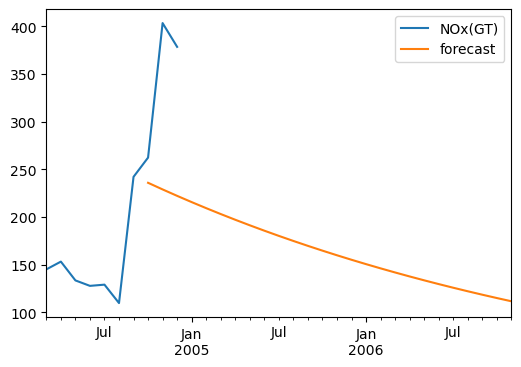

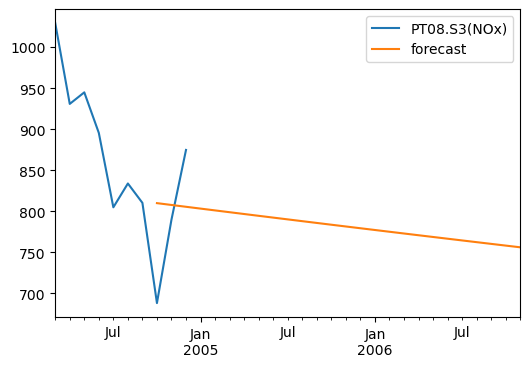

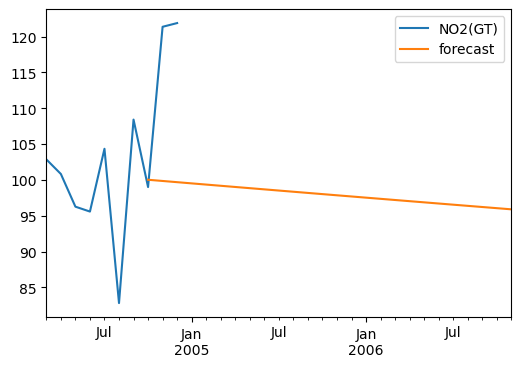

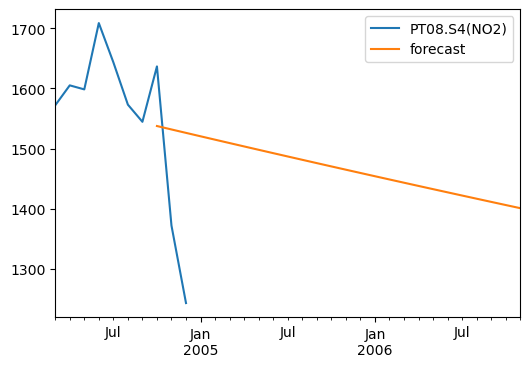

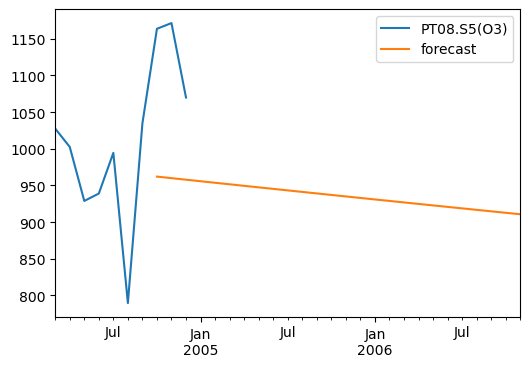

In [18]:
##For loop to loop through all the features to find the future chemical compound concentration and 
## the accuracy of the model as well as the forecasted values.
acc_comp = []
forecast = []  #pd.to_datetime(times_series_modeling(train, train.columns[0]).index)
for i in range(0, features.shape[1]):
    data = times_series_modeling(train, train.columns[i])
    acc_comp.append(accuracy(data, test, train.columns[i]))
    forecast.append(data['forecast'].T)

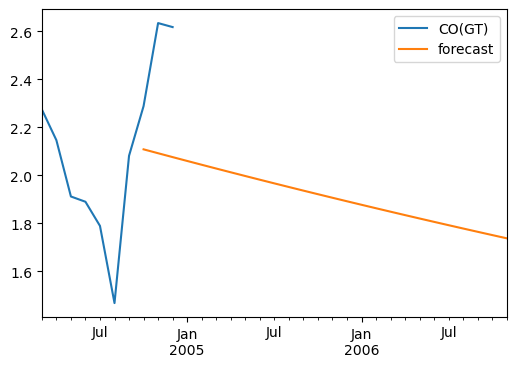

In [19]:
#Construct forecast dataframe
forecastvalues = pd.DataFrame(np.transpose(forecast), columns = features.columns, index = pd.to_datetime(times_series_modeling(train, train.columns[0]).index)).dropna()

In [20]:
forecastvalues

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)     NOx(GT)  \
2004-10-31  2.108169  1122.277988  9.964757     942.785729  235.788702   
2004-11-30  2.091894  1118.921888  9.964749     942.785585  228.841310   
2004-12-31  2.075745  1115.575824  9.964741     942.785441  222.098619   
2005-01-31  2.059720  1112.239767  9.964733     942.785296  215.554598   
2005-02-28  2.043819  1108.913686  9.964725     942.785152  209.203394   
2005-03-31  2.028041  1105.597551  9.964717     942.785007  203.039324   
2005-04-30  2.012384  1102.291333  9.964709     942.784863  197.056875   
2005-05-31  1.996848  1098.995002  9.964700     942.784718  191.250696   
2005-06-30  1.981433  1095.708529  9.964692     942.784574  185.615593   
2005-07-31  1.966136  1092.431883  9.964684     942.784430  180.146526   
2005-08-31  1.950957  1089.165036  9.964676     942.784285  174.838602   
2005-09-30  1.935896  1085.907958  9.964668     942.784141  169.687073   
2005-10-31  1.920951  1082.660621  9.964660     942.783996  164.687331   
2005-11-30  1.906121  1079.422994  9.964651     942.783852  159.834904   
2005-12-31  1.891406  1076.195049  9.964643     942.783708  155.125451   
2006-01-31  1.876804  1072.976758  9.964635     942.783563  150.554760   
2006-02-28  1.862315  1069.768090  9.964627     942.783419  146.118742   
2006-03-31  1.847938  1066.569018  9.964619     942.783274  141.813429   
2006-04-30  1.833672  1063.379512  9.964611     942.783130  137.634969   
2006-05-31  1.819516  1060.199544  9.964602     942.782986  133.579626   
2006-06-30  1.805469  1057.029086  9.964594     942.782841  129.643772   
2006-07-31  1.791531  1053.868109  9.964586     942.782697  125.823885   
2006-08-31  1.777700  1050.716584  9.964578     942.782552  122.116549   
2006-09-30  1.763976  1047.574484  9.964570     942.782408  118.518448   
2006-10-31  1.750358  1044.441781  9.964562     942.782264  115.026364   
2006-11-30  1.736845  1041.318445  9.964554     942.782119  111.637171   

            PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  
2004-10-31    809.966481  100.015288   1537.641918   962.041860  
2004-11-30    807.744360   99.846864   1531.935239   959.934271  
2004-12-31    805.528336   99.678723   1526.249738   957.831298  
2005-01-31    803.318391   99.510866   1520.585339   955.732933  
2005-02-28    801.114509   99.343291   1514.941961   953.639165  
2005-03-31    798.916674   99.175998   1509.319529   951.549984  
2005-04-30    796.724868   99.008988   1503.717962   949.465379  
2005-05-31    794.539075   98.842258   1498.137185   947.385342  
2005-06-30    792.359279   98.675809   1492.577120   945.309861  
2005-07-31    790.185463   98.509641   1487.037691   943.238927  
2005-08-31    788.017611   98.343752   1481.518819   941.172530  
2005-09-30    785.855707   98.178143   1476.020430   939.110660  
2005-10-31    783.699733   98.012812   1470.542448   937.053307  
2005-11-30    781.549674   97.847760   1465.084796   935.000461  
2005-12-31    779.405514   97.682986   1459.647399   932.952112  
2006-01-31    777.267237   97.518489   1454.230182   930.908251  
2006-02-28    775.134826   97.354270   1448.833070   928.868868  
2006-03-31    773.008265   97.190327   1443.455988   926.833952  
2006-04-30    770.887538   97.026660   1438.098862   924.803494  
2006-05-31    768.772629   96.863268   1432.761619   922.777484  
2006-06-30    766.663523   96.700152   1427.444183   920.755913  
2006-07-31    764.560202   96.537311   1422.146483   918.738771  
2006-08-31    762.462653   96.374743   1416.868443   916.726047  
2006-09-30    760.370857   96.212450   1411.609993   914.717733  
2006-10-31    758.284801   96.050430   1406.371058   912.713819  
2006-11-30    756.204467   95.888682   1401.151566   910.714295

In [21]:
#SARIMAX accuracy per compound
pd.DataFrame(acc_comp, columns =['SARIMAX Acc'], index = features.columns)

SARIMAX Acc
CO(GT)              0.8571
PT08.S1(CO)         0.8571
C6H6(GT)            0.7143
PT08.S2(NMHC)       0.7143
NOx(GT)             0.8571
PT08.S3(NOx)        0.5714
NO2(GT)             0.7143
PT08.S4(NO2)        0.5714
PT08.S5(O3)         0.8571

In [22]:
#Find overall model accuracy
np.mean(acc_comp)

0.7460111111111112

From the monthly line graphs of the time series analysis we see that there is a general trend for all compounds. The predictions tends to be in a constant linear line. Which indicates that maybe the SARIMAX model could be improved. However, when we look closely at the forecast values, we see that indeed after a certain point in time, the concentration values are indeed slightly similar which is why we see a constant trend moving forwards. 

Since we cannot accurately predict the concentration levels by decimal point. If we assume that our predicted values are within a .55 range of the actual values we can say that the concentration values match. As such, despite the plots looking like a constant trend, the SARIMAX model is 74.6% accuracy rate. The size of the comparison is only from Oct2004 to Apr2005 so there is a small sample size. If we had a larger sample size, then we could have a potentially higher accuracy. Morevoer since we do not have any available data after Apr2005 it is hard to compare our forecasted values. 

To improve the accuracy of the SARIMAX we could use seasonality, test a wider prediction date range or use a different order than (1,0,1).

Text(0.5, 1.0, "All Toxic Gases' Frequency by Month")

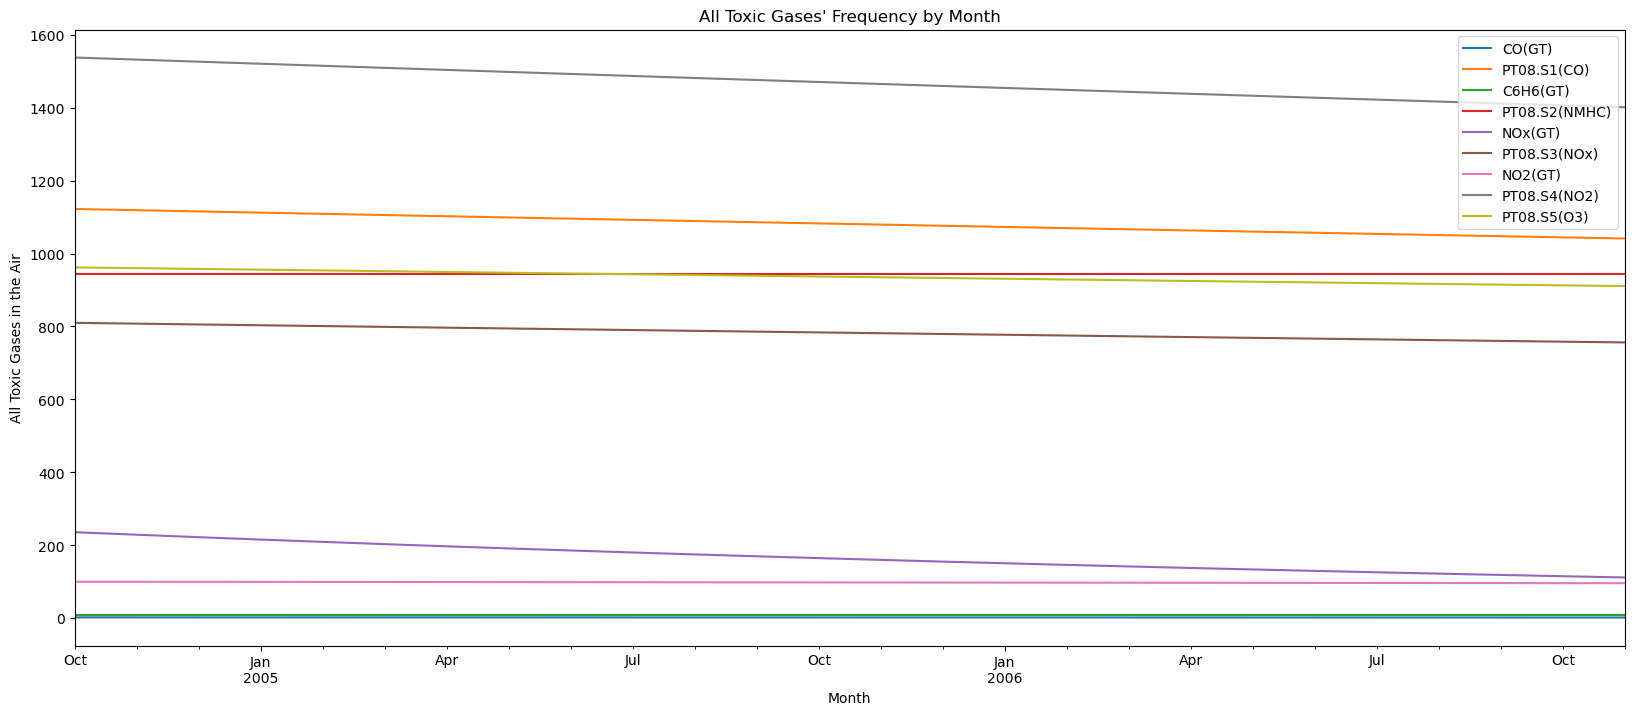

In [23]:
forecastvalues.plot(figsize = (20,8))
plt.legend(loc=1)
plt.xlabel('Month')
plt.ylabel('All Toxic Gases in the Air')
plt.title("All Toxic Gases' Frequency by Month")

The line graph displays what I have mentioned before that after a certain time frame, the future chemical compounds appear to remain constant.

<h1>Method 3: Cluster analysis on hourly and daily data using Kmeans clustering and PCA visualizations</h1>

## Hourly Grouping

The data is first grouped based on the hour an observation was collected. Then, the Elbow Method is employed for the purpose of determining the best number of clusters. The point where the rate of decrease sharply changes often indicates a good number of clusters to use. 

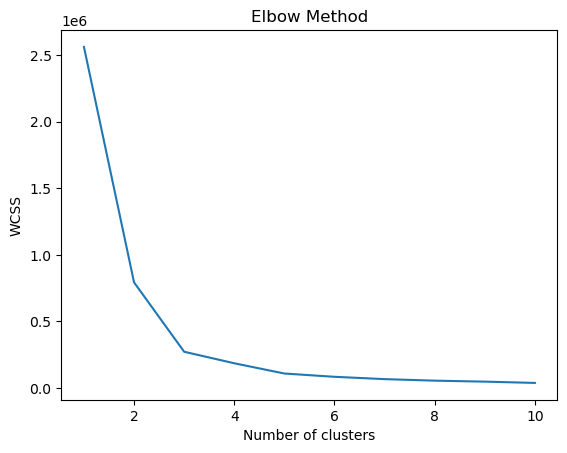

In [24]:
features2 = X.drop(['T'], axis=1)
features2['Hour'] = features2['Time']

# Group data by 'Hour' and calculate mean for other columns
hourly_data = features2.groupby('Hour').mean()

# Select only numerical columns for K-Means clustering
numerical_hourly_data = hourly_data.select_dtypes(include=['number'])

# Apply K-Means clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(numerical_hourly_data)  # Fit model on numerical data
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose the number of clusters based on the plot
n_clusters = 3  # Adjust based on the Elbow plot
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_clusters = kmeans.fit_predict(numerical_hourly_data)  # Predict clusters

In [25]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_clusters_2 = kmeans_2.fit_predict(numerical_hourly_data)

# Apply K-Means clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_clusters_3 = kmeans_3.fit_predict(numerical_hourly_data)

# Create a DataFrame to see hours and their corresponding clusters for 2 clusters
hourly_cluster_2 = pd.DataFrame({'Hour': numerical_hourly_data.index, 'Cluster': y_clusters_2})
print("Hourly Clusters with n=2")
print(hourly_cluster_2.sort_values(by='Cluster'))

# Do the same for 3 clusters
hourly_cluster_3 = pd.DataFrame({'Hour': numerical_hourly_data.index, 'Cluster': y_clusters_3})
print("\n\nHourly Clusters with n=3")
print(hourly_cluster_3.sort_values(by='Cluster'))

Hourly Clusters with n=2
    Hour  Cluster
0      0        0
21    21        0
20    20        0
19    19        0
18    18        0
17    17        0
16    16        0
15    15        0
14    14        0
13    13        0
12    12        0
11    11        0
10    10        0
9      9        0
8      8        0
7      7        0
22    22        0
23    23        0
6      6        1
5      5        1
4      4        1
3      3        1
2      2        1
1      1        1


Hourly Clusters with n=3
    Hour  Cluster
20    20        0
19    19        0
18    18        0
17    17        0
8      8        0
9      9        0
10    10        0
0      0        1
21    21        1
16    16        1
15    15        1
14    14        1
13    13        1
11    11        1
22    22        1
7      7        1
12    12        1
23    23        1
6      6        2
5      5        2
4      4        2
3      3        2
2      2        2
1      1        2


Although the graph output of the Elbow method would indicate that the best number of clusters based on the point of steepest descent is at n=2, n=3 clusters is chosen as this may yield more interesting and interpretable results in the hourly grouping case. 

In [26]:
cluster_hours = {}

# Populate the dictionary with the sorted hours for each cluster
for cluster_num in hourly_cluster_3['Cluster'].unique():
    cluster_hours[cluster_num] = hourly_cluster_3[hourly_cluster_3['Cluster'] == cluster_num]['Hour'].sort_values().tolist()

# Display the organized hours by cluster
for cluster_num, hours in cluster_hours.items():
    print(f"Cluster {cluster_num}: {hours}")
    
sorted_hourly_cluster = hourly_cluster_3.sort_values(by='Hour')

# Display each hour with its associated cluster
print(sorted_hourly_cluster)

Cluster 1: [0, 7, 11, 12, 13, 14, 15, 16, 21, 22, 23]
Cluster 2: [1, 2, 3, 4, 5, 6]
Cluster 0: [8, 9, 10, 17, 18, 19, 20]
    Hour  Cluster
0      0        1
1      1        2
2      2        2
3      3        2
4      4        2
5      5        2
6      6        2
7      7        1
8      8        0
9      9        0
10    10        0
11    11        1
12    12        1
13    13        1
14    14        1
15    15        1
16    16        1
17    17        0
18    18        0
19    19        0
20    20        0
21    21        1
22    22        1
23    23        1


**Cluster 1 (0, 7, 11-16, 21-23):**

This cluster includes the early morning hour of 7:00 AM, the early to late afternoon hours between 11:00 AM and 4:00 PM, and the late evening hours between 9:00 PM and midnight. The presence of disjointed hourly intervals suggests a pattern in which pollution levels are in transition, possibly due to factors such as traffic and industrial activities being either in an active state of increase or decrease.

**Cluster 2 (1-6):**

These hours cover the very early morning hours between 1:00 AM and 6:00 AM. The fact that it encompasses a distinct, continuous interval of time suggests a unique air quality profile, most likely characterized by the lowest levels of pollution due to minimal human activity.

**Cluster 0 (8-10, 17-20):**

This cluster encompasses the morning hours from 8:00 AM to 10:00 AM and the late afternoon to evening hours from 5:00 PM to 8:00 PM. These times are usually associated with rush hours and increased traffic, potentially leading to higher readings on the roadside chemcial sensors.

Based on these groupings, a general profile can be determined for each cluster. For example:

Cluster 2 might correspond to the times with the lowest pollution levels

Cluster 1 might correspond to moderate pollution levels

Cluster 0 might correspond to the highest pollution levels

We make these infrences based on general patterns of human activity.

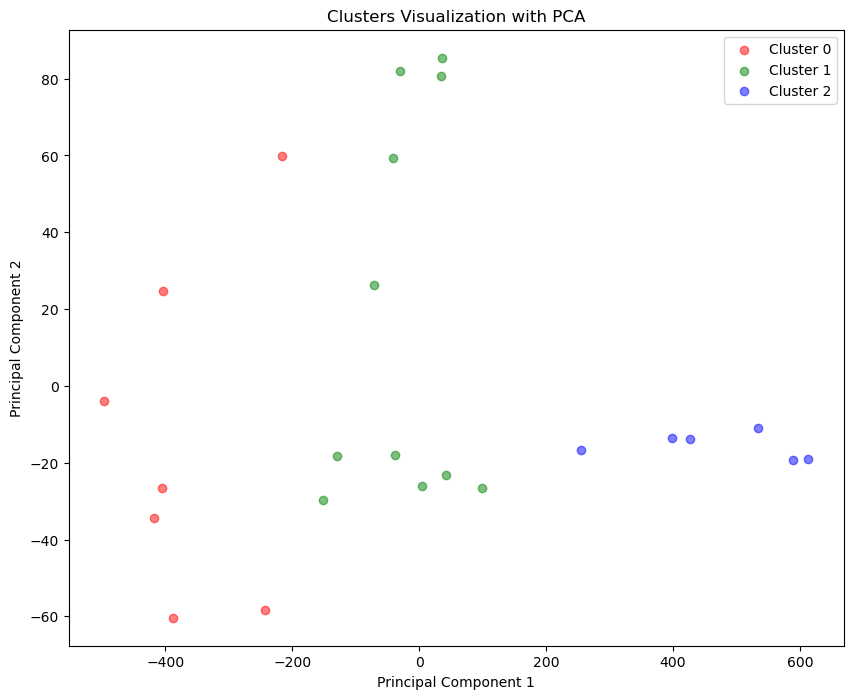

In [27]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(numerical_hourly_data)

# Create a DataFrame with the principal components and cluster labels
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = y_clusters_3

# Plotting the clusters
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']
for cluster in range(3):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.5, color=colors[cluster])

plt.title('Clusters Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

PCA was utilized for the purpose of dimensionality reduction in order to visualize and interpret the clusters in conjunction with variables (pollutants) of interest.

In [28]:
pca.fit(numerical_hourly_data)

# The components are stored here:
loadings = pca.components_
# Create a DataFrame for the loadings for easier interpretation
loadings_df = pd.DataFrame(loadings.T,  # Transpose the loadings matrix
                            columns=['PC1', 'PC2'],  # Name the columns as principal components
                            index=numerical_hourly_data.columns)  # Use the original feature names as the index

print("Loadings for hourly clustering:")
print(loadings_df)

print("\nLoadings for PC1 sorted by absolute value:")
print(loadings_df['PC1'].abs().sort_values(ascending=False))

print("\nLoadings for PC2 sorted by absolute value:")
print(loadings_df['PC2'].abs().sort_values(ascending=False))

Loadings for hourly clustering:
                    PC1       PC2
Time          -0.012857  0.043900
CO(GT)        -0.002025  0.000949
PT08.S1(CO)   -0.341426  0.160867
C6H6(GT)      -0.012625  0.009987
PT08.S2(NMHC) -0.487331  0.494264
NOx(GT)       -0.223430  0.041824
PT08.S3(NOx)   0.386417 -0.276327
NO2(GT)       -0.061417  0.083437
PT08.S4(NO2)  -0.409818 -0.018347
PT08.S5(O3)   -0.523884 -0.787037
RH             0.013869 -0.151544
AH             0.000014 -0.000506

Loadings for PC1 sorted by absolute value:
PT08.S5(O3)      0.523884
PT08.S2(NMHC)    0.487331
PT08.S4(NO2)     0.409818
PT08.S3(NOx)     0.386417
PT08.S1(CO)      0.341426
NOx(GT)          0.223430
NO2(GT)          0.061417
RH               0.013869
Time             0.012857
C6H6(GT)         0.012625
CO(GT)           0.002025
AH               0.000014
Name: PC1, dtype: float64

Loadings for PC2 sorted by absolute value:
PT08.S5(O3)      0.787037
PT08.S2(NMHC)    0.494264
PT08.S3(NOx)     0.276327
PT08.S1(CO)      0.160

We sort the loadings in order of decreasing absolute value in order to determine the greatest contributors to PC1 and PC2 and determine that O3 is the greatest contributor to both PC1 and PC2. A negative value on the original loading on PC1, however, indicates that as the ozone levels increase, the values on PC1 decrease and that there is an inverse relationship between the two. 

The fact that the original loading for O3 is negative and Cluster 0 is to the left of the PC1 axis means that Cluster 0 represents times of the day with the highest levels of ozone pollution. The next highest according to the Cluster Visualization graph would be Cluster 1, followed by Cluster 2. This is consistent with the fact that Cluster 1 is associated with moderate or transitional levels of human activity and Cluster 2 is associated with the lowest level of human activity, in which there would be the lowest levels of chemicals detected by the sensors.

In [29]:
numerical_hourly_data['Cluster'] = y_clusters

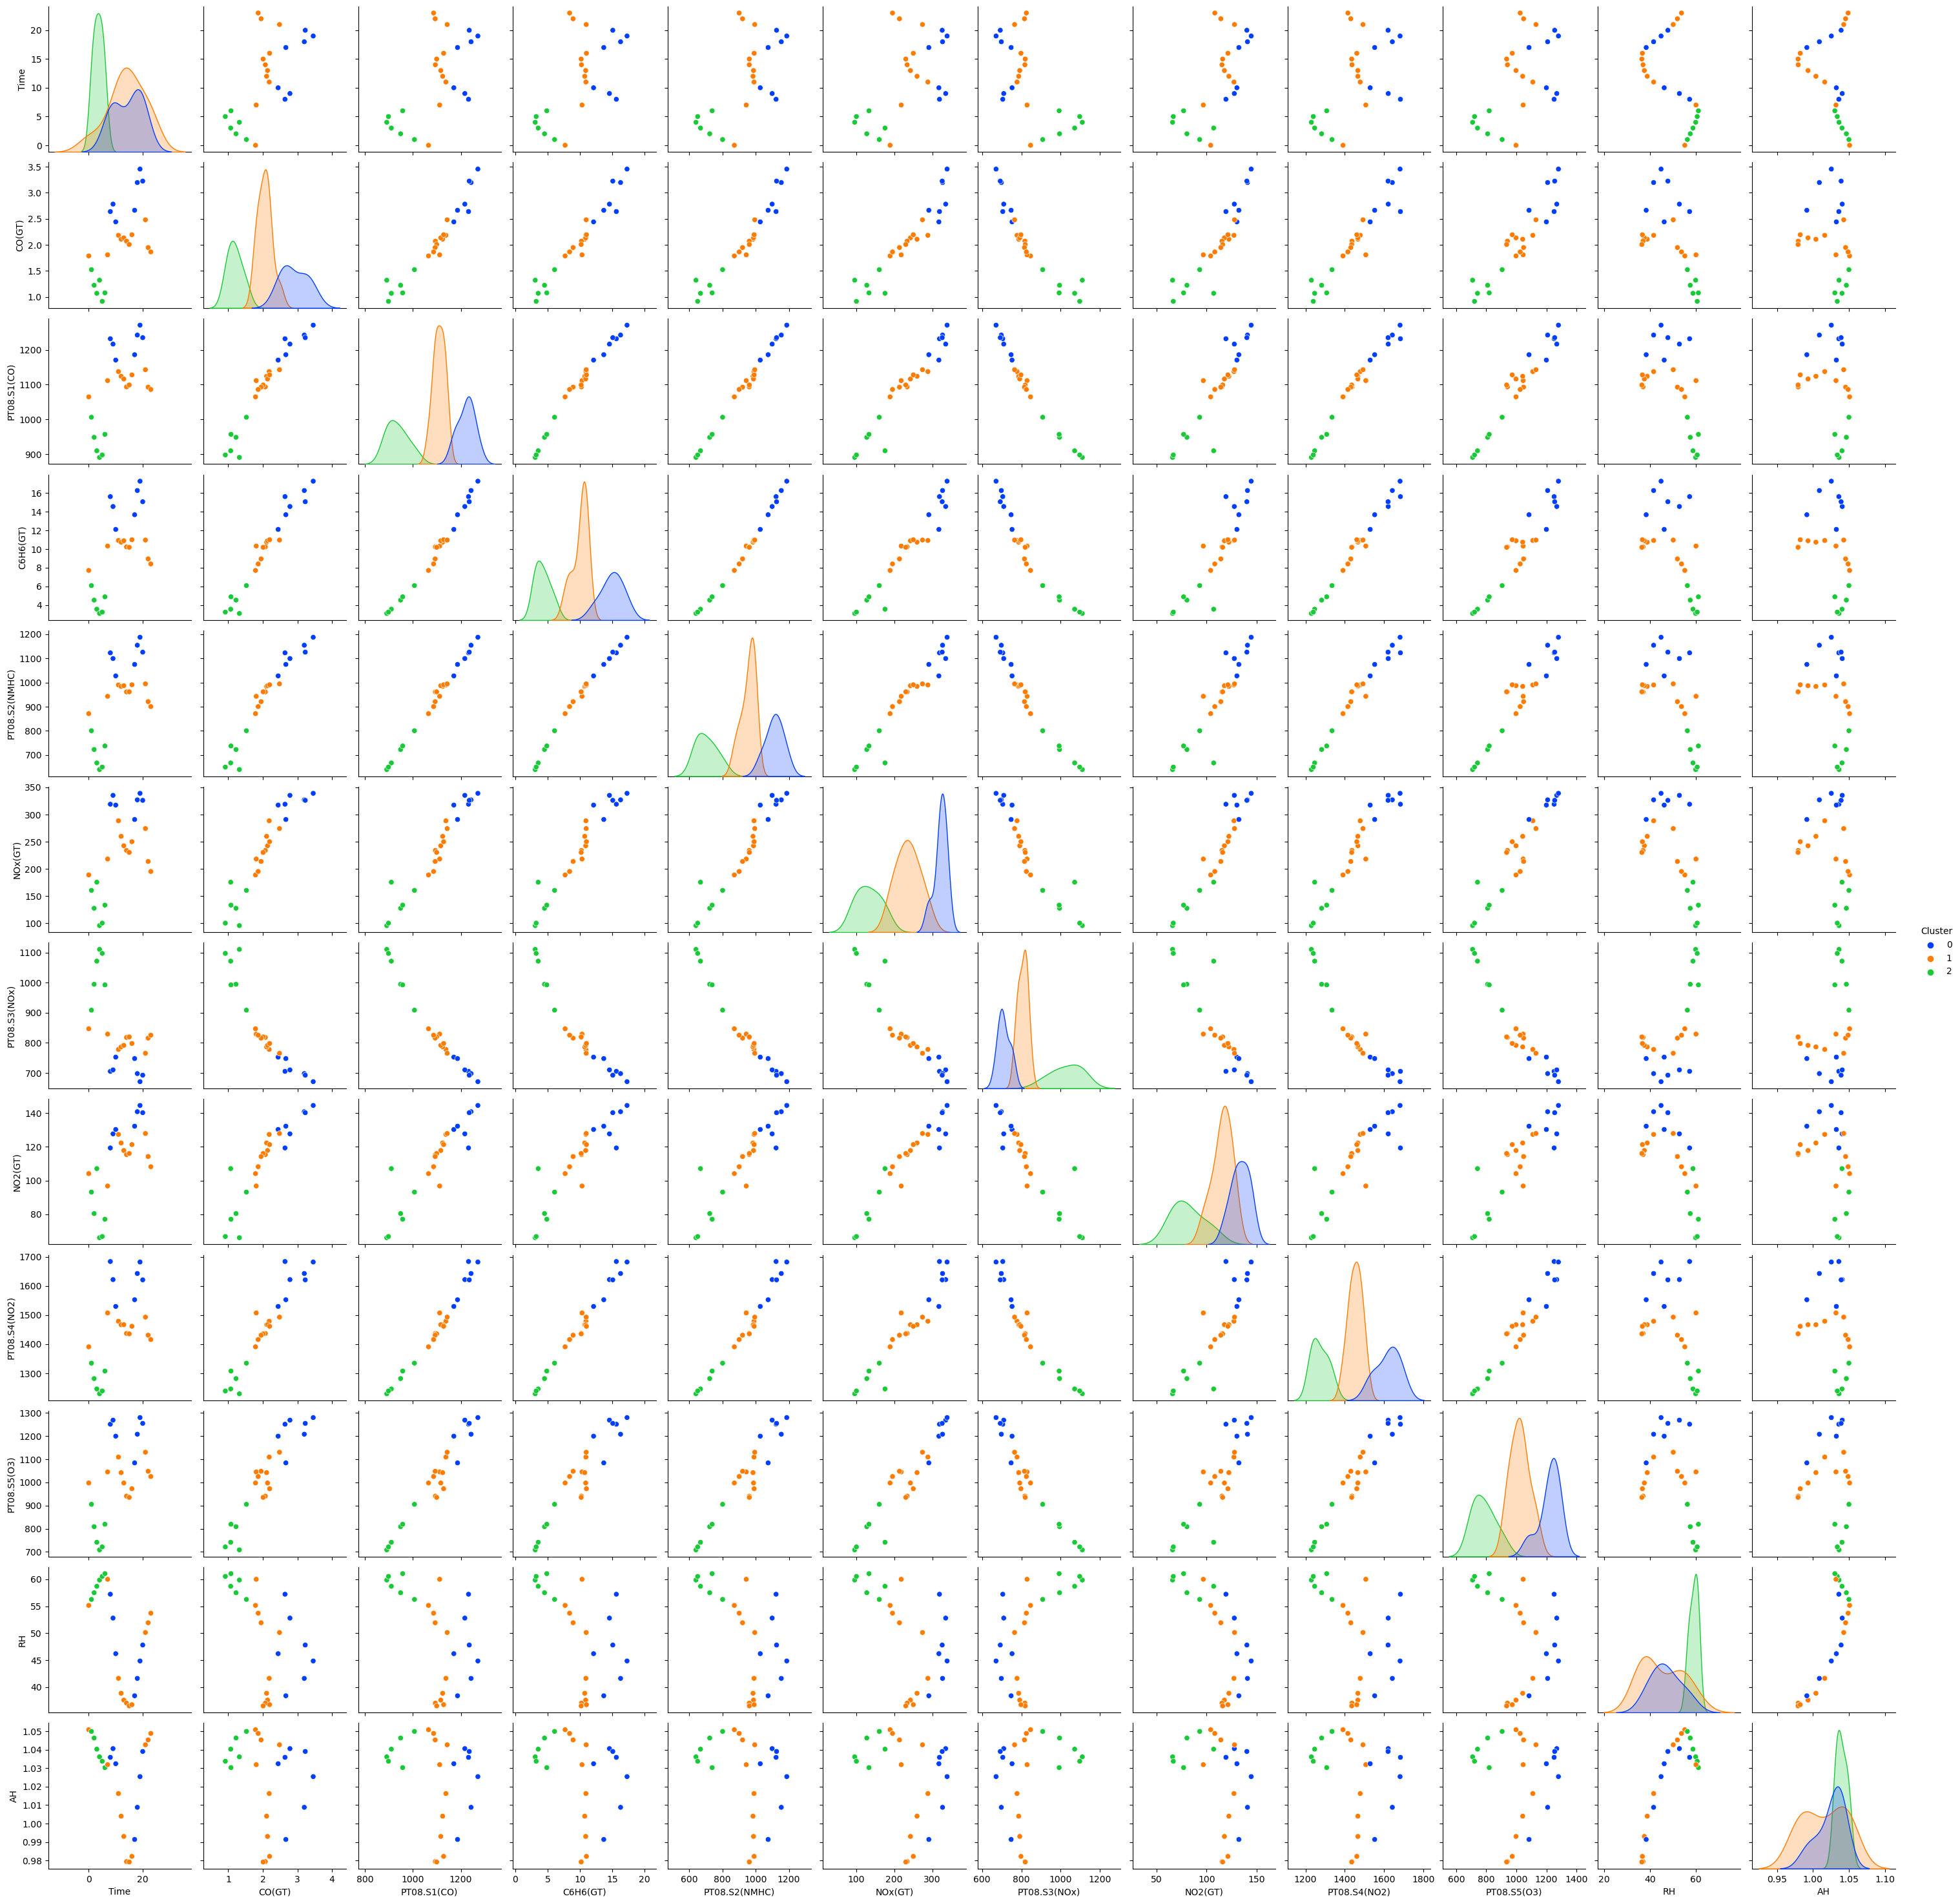

In [30]:
sbn.pairplot(numerical_hourly_data, hue='Cluster', palette='bright')
plt.show()

A pairplot is constructed in order to display the relationships between various features of the air quality dataset, with data points colored according to cluster membership. The plots along the diagonal show the distribution of each feature against itself within each cluster. Features that show consistency in separating the clusters across multiple plots are considered to be good at differentiating between the clusters and may be more influential in characterizing air quality on different hours. On the other hand, more overlapping clusters indicate less differentiation between the clusters based on the pair of features being compared. 

In this case, we notice most are bell-shaped, albeit with some skewness in various cases. Many of the plots show a clear trend- either a positive linear one or a negative linear one. In addition, there appears to be clear differentiation between the clusters in most of the scatter plots, with the overlapping cases occuring in the scatter plots along the outermost edge of the pairplot. This may indicate that the most influential features in characterizing air quality are the concentrations of the various chemical compounds themselves, rather than other features such as relative and absolute humidity, time and temperature, although these are useful to consider for other purposes.

In [31]:
centroids_manual = sorted_hourly_cluster.groupby('Cluster').mean()

centroids_manual_2 = numerical_hourly_data.groupby('Cluster')[['PT08.S5(O3)', 'PT08.S2(NMHC)']].mean()

print("Centroids for Features 1,2 and 3:")
print("\n",centroids_manual)
print(centroids_manual_2)

Centroids for Features 1,2 and 3:

               Hour
Cluster           
0        14.428571
1        14.000000
2         3.500000
         PT08.S5(O3)  PT08.S2(NMHC)
Cluster                            
0        1220.660463    1112.848975
1        1022.074786     954.794637
2         784.314103     703.205983


Further support for the assertion that Clusters 0, 1, and 2 correspond to the highest, moderate, and lowest levels of human activity and air pollution respectively lies in the fact that the centroids (means) for each cluster for O3 and Nonmethane Hydrocarbon (NMHC) are also in decreasing order. 

## Daily Grouping

We now consider the dataset in terms of daily groupings and proceed to utilize the Elbow Method to determine the best number of clusters for analysis.

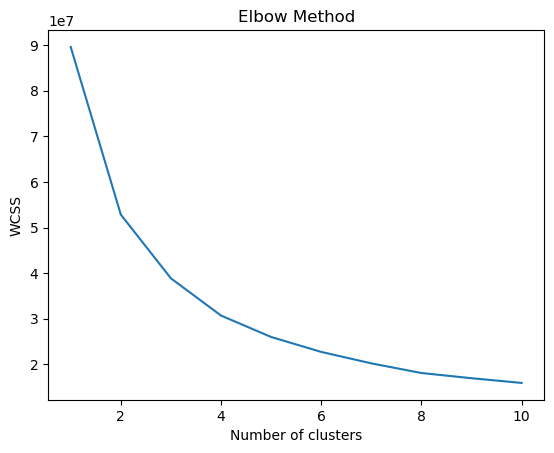

In [32]:
# Aggregate data by day
daily_data = features2.resample('D').mean()  # 'D' for day

numerical_daily_data = daily_data.select_dtypes(include=['number'])

# Perform K-Means clustering
# First, determine the number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(daily_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Choose the number of clusters (let's say n_clusters)
n_clusters = 4  # Replace with your chosen number
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_clusters = kmeans.fit_predict(numerical_daily_data)


It is seemingly less straightforward to determine the ideal number of clusters based on this Elbow Method output due to the fact that the curve appears smoother when clustering daily than when clustering hourly. Therefore, we utilize the Silhouette Score for further insight.

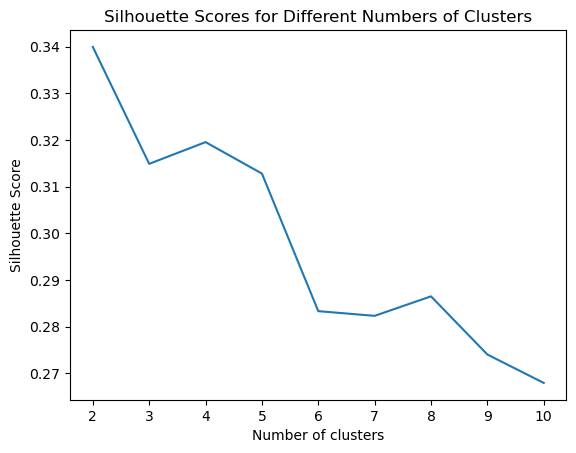

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    y_clusters = kmeans.fit_predict(daily_data)
    score = silhouette_score(daily_data, y_clusters)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Although n=2 has the highest Silhouette Score of 0.34, a more prudent option would be to choose n=4, whose Silhouette Score is only two hundreths less than n=2, and see if this provides information about seasonal changes in the region, as Italy indeed is considered to have four seasons.  

In [34]:
kmeans_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
y_clusters_4 = kmeans_4.fit_predict(daily_data)

daily_cluster_4 = pd.DataFrame({'D': daily_data.index, 'Cluster': y_clusters_4})
print(daily_cluster_4.sort_values(by='Cluster'))

             D  Cluster
342 2005-02-15        0
324 2005-01-28        0
325 2005-01-29        0
326 2005-01-30        0
270 2004-12-05        0
..         ...      ...
132 2004-07-20        3
131 2004-07-19        3
128 2004-07-16        3
142 2004-07-30        3
195 2004-09-21        3

[391 rows x 2 columns]


Since there are more days in the year than hours in the day, it is more difficult to know which specific days comprise each specific cluster. For this reason, we plot the general location of the data points along the entirety of data collection period From March 2004 to April 2005.

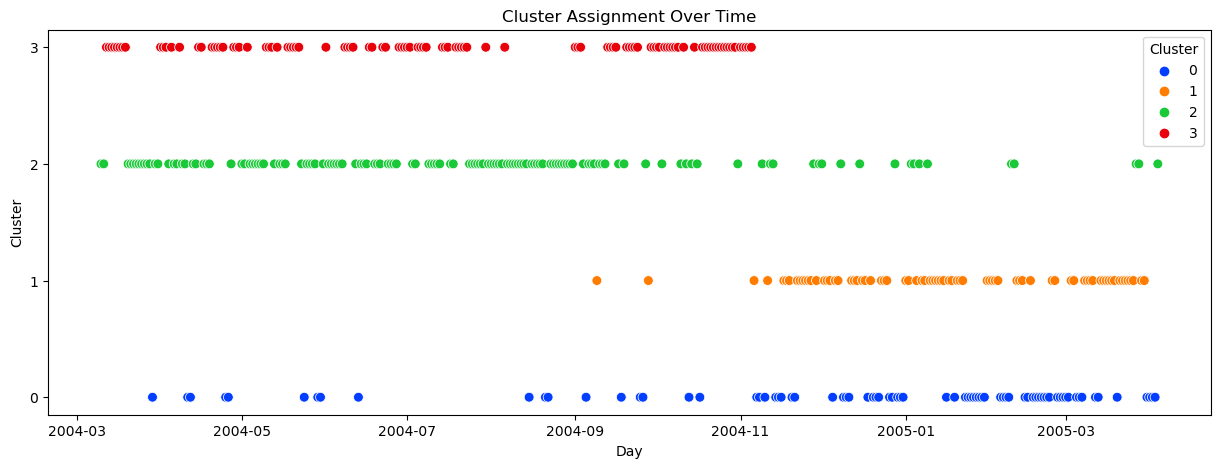

In [35]:
daily_cluster_4['D'] = pd.to_datetime(daily_cluster_4['D'])

# Plot each day's cluster assignment over time
plt.figure(figsize=(15, 5))
sbn.scatterplot(x='D', y='Cluster', data=daily_cluster_4, hue='Cluster', palette='bright', s=50)
plt.title('Cluster Assignment Over Time')
plt.xlabel('Day')
plt.ylabel('Cluster')
plt.yticks(range(4))
plt.legend(title='Cluster')
plt.show()


In [36]:
cluster_date_counts = daily_cluster_4['Cluster'].value_counts().sort_index()

# Output the number of dates in each cluster
print(cluster_date_counts)

Cluster
0     77
1     75
2    136
3    103
Name: count, dtype: int64


**Cluster 0:**

Cluster 0 displays sporadic prescence throughout March to October 2004 with more concentrated occurances in November 2004 thru the early months of 2005, possibly indicating a transitional period in which certain air quality characteristics decrease in warmer temperatures and increase in colder temperatures.

**Cluster 1:**

This cluster seems entirely concentrated in the colder months between November 2004 and April 2005. This might indicate a set of air quality characteristics completely associated with colder temperatures.

**Cluster 2:**

This cluster is also present throughout the data collection period but is more prevalent in the months associated with warmer weather, possibly indicating a transitional period and air quality conditions that increase in warmer temperatures and decrease in colder temperatures.

**Cluster 3:**

Cluster 3 has consistent occurances from March 2004 to November 2004, corresponding to the warmest temperatures of the year and an air quality profile associated with those months.

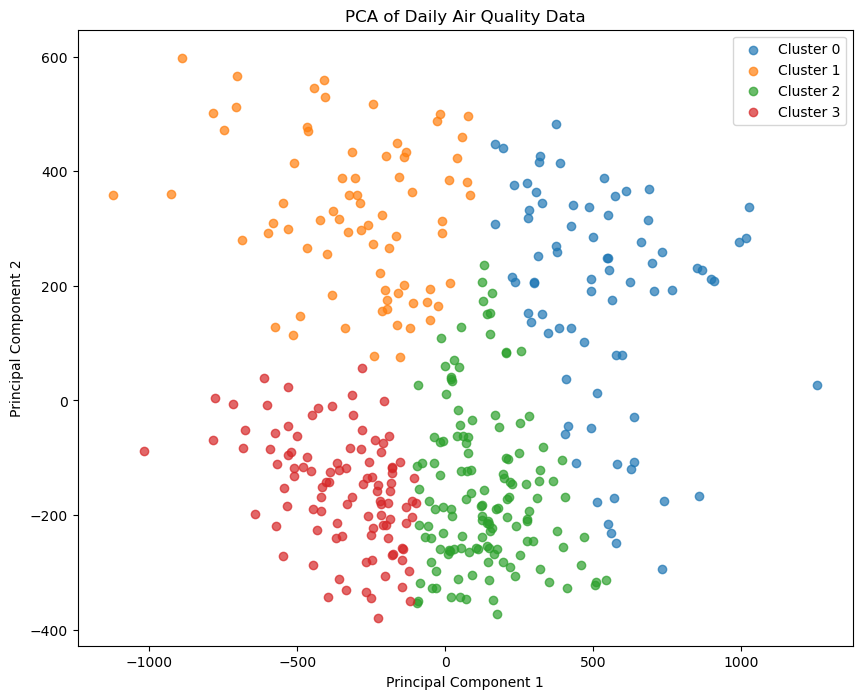

In [37]:
n_clusters=4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
daily_clusters = kmeans.fit_predict(daily_data)

# Perform PCA to reduce data to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(daily_data)

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = daily_clusters

# Plot the PCA-reduced data
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('PCA of Daily Air Quality Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

The output of the PCA of daily air quality data shows four distinct clusters with some, but minimal overlap in the areas where one cluster meets another. 

In [38]:
# Assuming 'daily_data' is the data you used for PCA
pca = PCA(n_components=2)
pca.fit(daily_data)

# The components are stored here:
loadings = pca.components_

# Create a DataFrame of loadings with feature names for easier interpretation
loadings_df = pd.DataFrame(loadings.T, index=daily_data.columns, columns=['PC1', 'PC2'])

# Print the loadings for interpretation
print("Loadings for daily clustering:")
print(loadings_df)

Loadings for daily clustering:
                    PC1       PC2
Time          -0.000013 -0.000094
CO(GT)        -0.001445  0.000806
PT08.S1(CO)   -0.317529  0.079384
C6H6(GT)      -0.009776 -0.000612
PT08.S2(NMHC) -0.360733 -0.041622
NOx(GT)       -0.186004  0.401884
PT08.S3(NOx)   0.339174 -0.182325
NO2(GT)       -0.026485  0.082073
PT08.S4(NO2)  -0.454363 -0.818441
PT08.S5(O3)   -0.641919  0.347048
RH            -0.010268  0.013639
AH            -0.000354 -0.001047
Hour          -0.000013 -0.000094


In [39]:
sorted_loadings_pc1 = loadings_df['PC1'].abs().sort_values(ascending=False)
sorted_loadings_pc2 = loadings_df['PC2'].abs().sort_values(ascending=False)

print("Loadings for PC1, ordered by absolute value:")
print(sorted_loadings_pc1)
print("\nLoadings for PC2, ordered by absolute value:")
print(sorted_loadings_pc2)

Loadings for PC1, ordered by absolute value:
PT08.S5(O3)      0.641919
PT08.S4(NO2)     0.454363
PT08.S2(NMHC)    0.360733
PT08.S3(NOx)     0.339174
PT08.S1(CO)      0.317529
NOx(GT)          0.186004
NO2(GT)          0.026485
RH               0.010268
C6H6(GT)         0.009776
CO(GT)           0.001445
AH               0.000354
Time             0.000013
Hour             0.000013
Name: PC1, dtype: float64

Loadings for PC2, ordered by absolute value:
PT08.S4(NO2)     0.818441
NOx(GT)          0.401884
PT08.S5(O3)      0.347048
PT08.S3(NOx)     0.182325
NO2(GT)          0.082073
PT08.S1(CO)      0.079384
PT08.S2(NMHC)    0.041622
RH               0.013639
AH               0.001047
CO(GT)           0.000806
C6H6(GT)         0.000612
Hour             0.000094
Time             0.000094
Name: PC2, dtype: float64


We again sort the loadings in order of decreasing absolute value in order to determine the greatest contributors to PC1 and PC2. Like in the hourly clustering, O3 is the greatest contributor to PC1, however, in this case, NO2 is the greatest contributor to PC2. The fact that their original loadings are both negative indicates an inverse relationship between the observed feature values and the principal component values. 

As such, the fact that the red cluster 3, corresponding to the warmest months and temperatures appears in the lower left corner of the PCA output graph shows that days in this cluster are associated with both higher levels of O3 and higher levels of NO2. This makes sense since the intensity of the sunlight is at its highest during warmer, spring and summer months. 

The orange cluster 1 appears as a somewhat scattered cluster in the upper left corner, indicating an association of the coldest temperatures with higher levels of O3 and lower levels of NO2, though an association that is not as strong as the red cluster. This may be counterintuitive, since colder months may have decreased levels of sunlight as the sky is inhibited by cloud cover, resulting in less photochemical reactions. However, cloud cover is not enough to completely inhibit UV light which causes the formation of ozone as a result of the interactions between it and Nitrogen compounds. With that said, colder temperatures also affect the chemistry of NO2 in the atmosphere, possibly leading to its reduction or conversion into other nitrogen compounds. Other environmental factors such as snow reflections and temperature inversions may explain the relatively higher levels of O3 associated with this cluster.

The blue cluster 0 appears as the most scattered in the rightmost portion of the graph. This is consistent with the fact that it is here interpreted as having transitional characteristics from sporadic observations in the warmer months to more consistent observations in the colder months. This cluster is associated with lower O3 levels and widespread levels of NO2, indicating that some days in this cluster have low levels of NO2 and others have higher levels of NO2.

The green cluster 3 is a densely packed cluster in the center of the graph associated with moderate levels of O3 and varying levels of NO2, which supports the fact that it too is interpreted as a transitional air quality profile with sporadic observations in the colder months and more consistent observations in the warmer months.

In [40]:
numerical_daily_data['Cluster'] = y_clusters_4

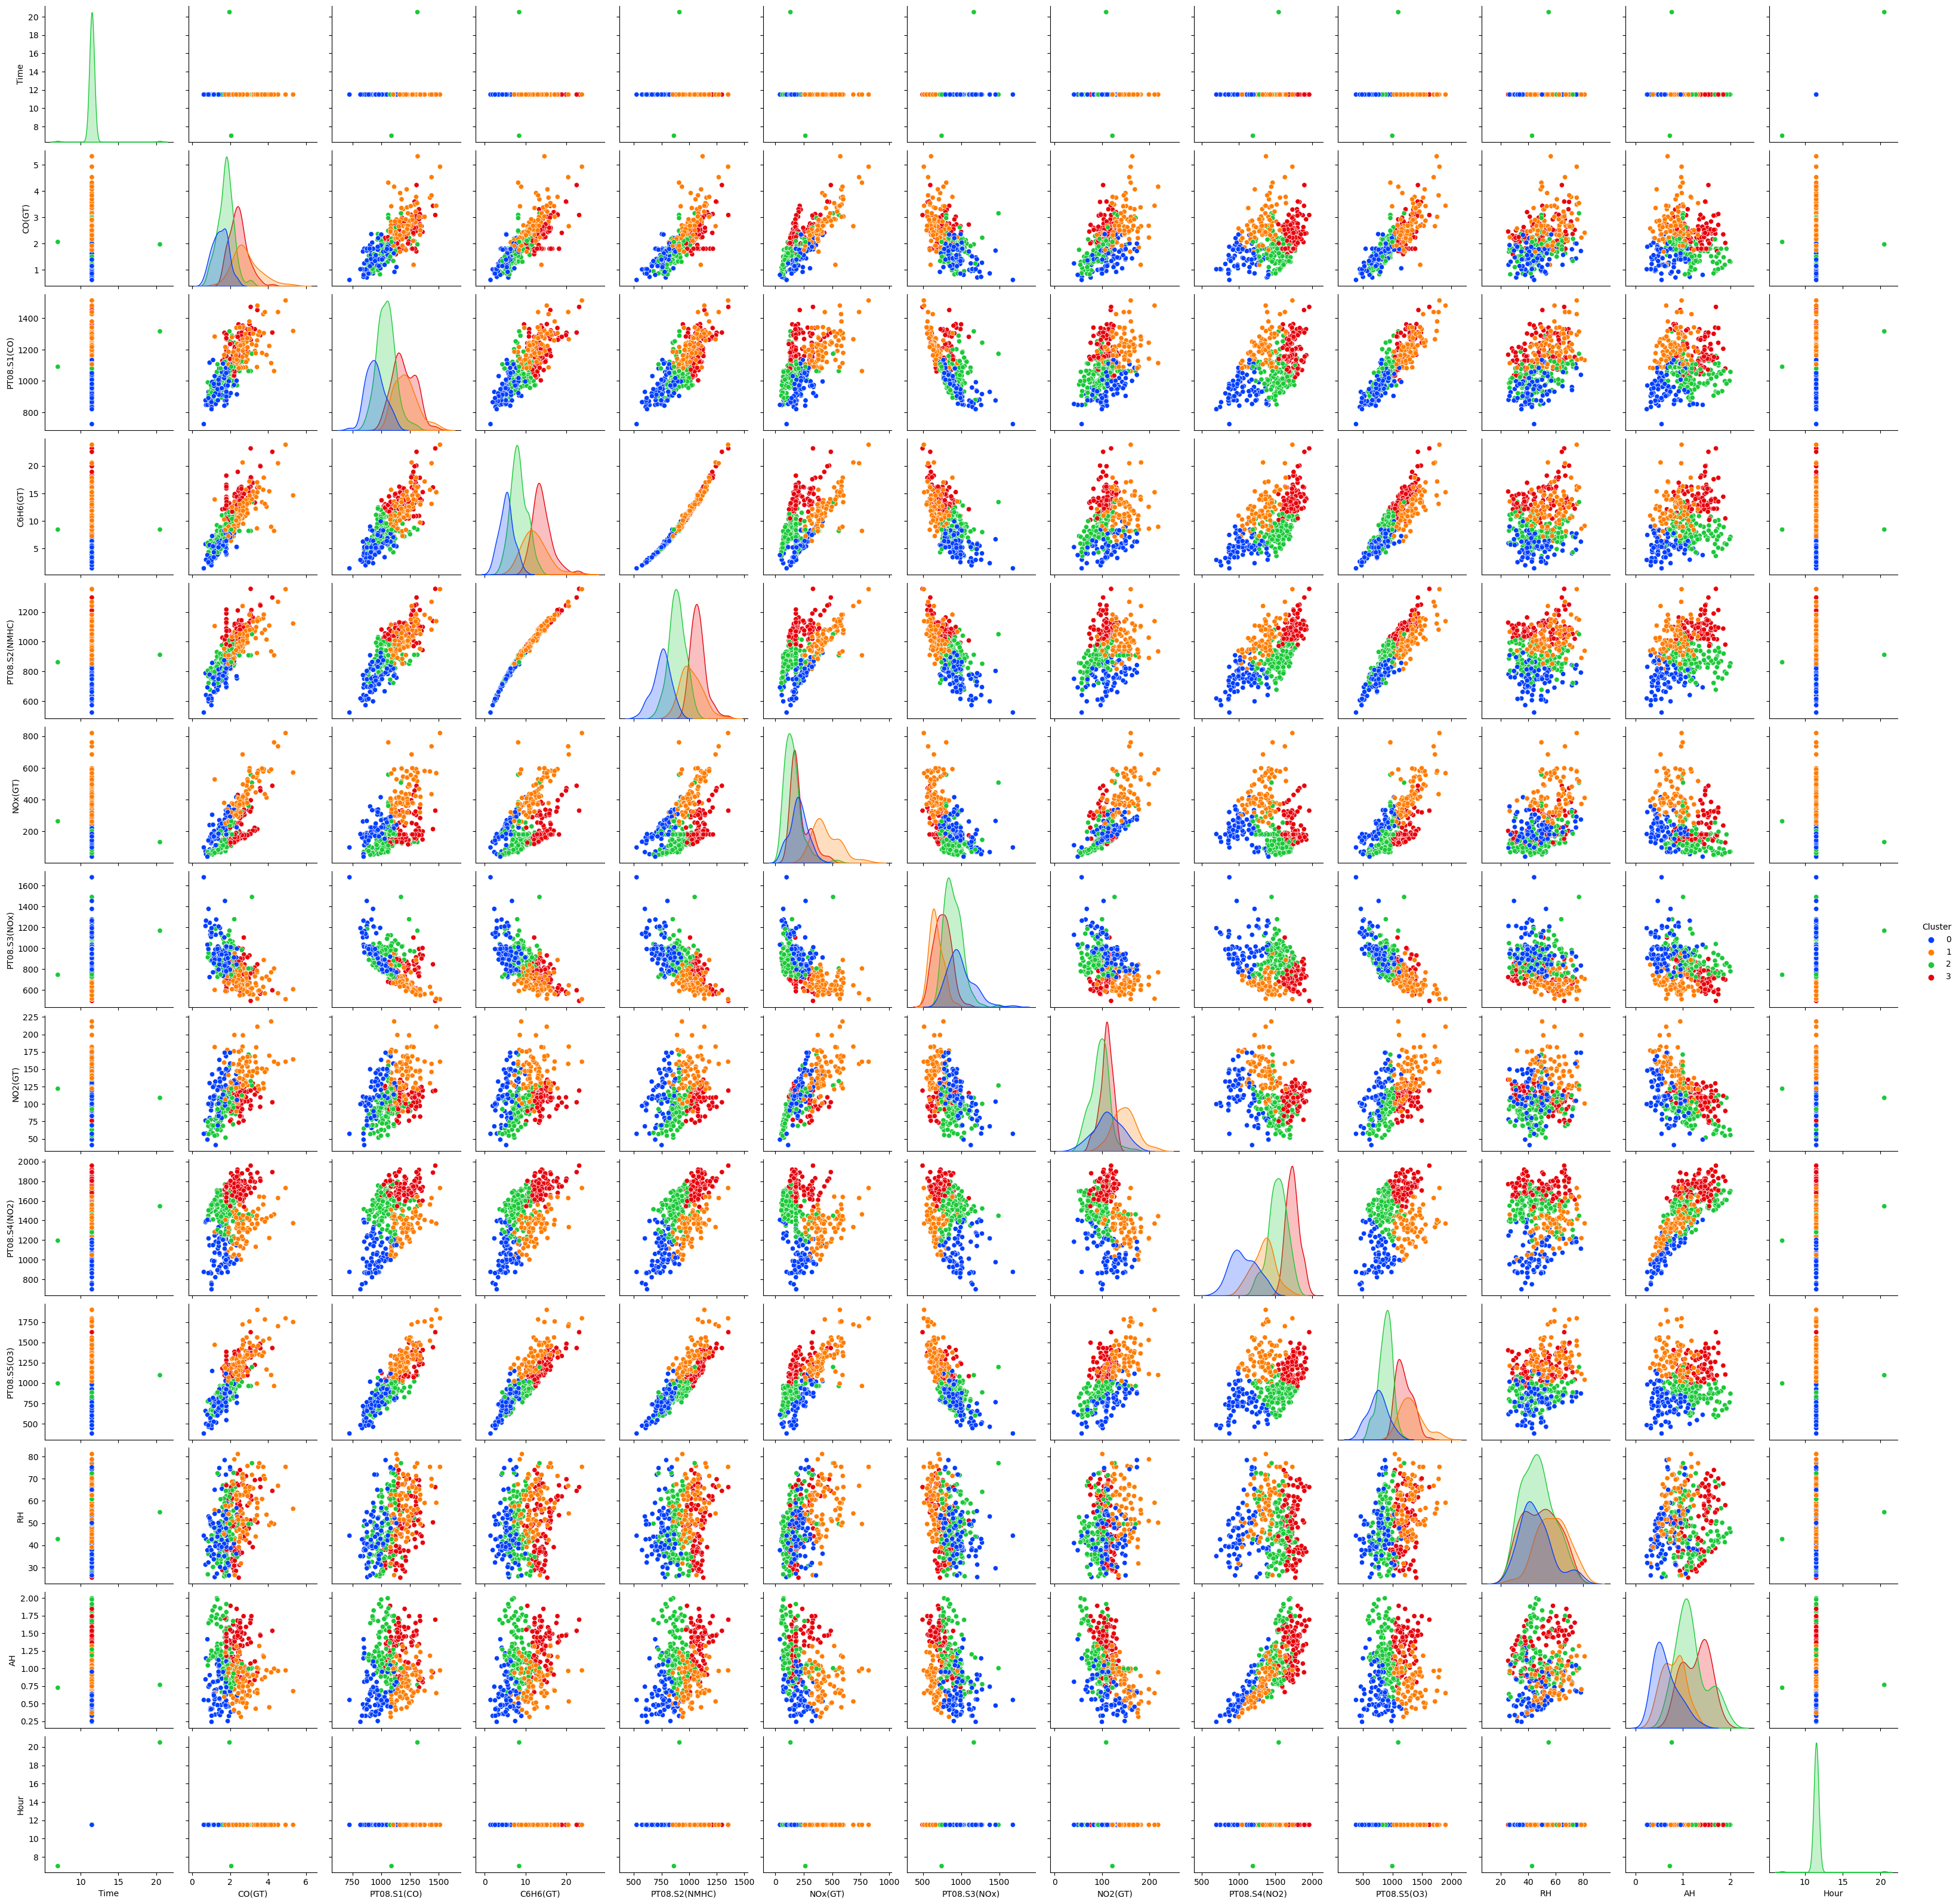

In [41]:
sbn.pairplot(numerical_daily_data, hue='Cluster', palette='bright')
plt.show()

In scatterplots presented in this pairplot, there is increased skewness in the bell-shaped curves in the daily grouping than in the hourly grouping. The way the clusters appear are also much more cloud-like here than in the hourly case, making clearly defined linear trends less noticeable, though still present in certain instances. Overlapping is also more common here, though a general discernable separation between clusters is still evident.  

# Conclusion

Overall we have gathered many insights on pollution from our analysis. In the short term, scientists can use either the KNN regressor or the Decision Tree regressor (since they have the highest accuracies) to predict the chemical compound concentrations. In the long term, scientists can use the SARIMAX model to predict the concentration of chemicals up to two years in advance. In both the short term and long term, scientist can create targeted interventions and better allocate resources to decrease the level of certain compounds that they are most interested/worried about.

Moreover, the cluster analysis provides valuable insight into human activity's impact on air quality, as several key patterns arose. Namely,  hourly clustering showed that clusters associated with increased levels of human activity (based on western cultural norms and presumptions) higher concentrations O3 pollution. In the daily clustering case, four distinct clusters and their corresponding levels of O3 and NO2 were consistent with increasing and decreasing levels of UV light associated with seasonal fluctuations. 